# Данные парсера маркетплейсов Wildberries и Яндекс.Маркет

Визуализация и анализ данных маркетплейсов, приведение описания из Wildberries к модели Яндекс.Маркет. Производится предобработка данных и проверка на соответствие теме (в данном случае "Отопительные котлы"), а также применяются различные способы и модели для создания таблицы Wildberries с характеристиками в формате Яндекс.Маркет

In [3]:
# Загрузка необходимых библиотек
import re
import pandas as pd
import functions as f

import pyLDAvis.gensim as gensimvis
import pyLDAvis

from matplotlib import pyplot as plt
import numpy as np

import os
import getpass

from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.text_splitter import NLTKTextSplitter

from nltk.tokenize import sent_tokenize
from itertools import chain

import spacy
from spacy.matcher import Matcher
nlp = spacy.load("ru_core_news_md")

pd.set_option('display.max_colwidth', 200)

### 1. Предобработка данных

##### Загрузка и обзор данных

* <b>Загрузка и форматирование</b>. Загружаем и форматируем данные: сразу токенизируем тексты описания товаров и разворачиваем по столбцам словари атрибутов товаров
* <b>Разделение данных</b>. Для удобства дальнейшего анализа разделяем данные по столбцам на основные (наименование товара, описание, цены и т.д.) и данные с атрибутами
* <b>Обзор данных</b>. Делаем предварительный обзор основных данных

In [4]:
# Загружаем csv-файлы с товарами маркетплейсов Wildberries и Яндекс.Маркет и получаем предобработанные данные с токенизированными текстами описания и развернутым по столбцам словарями характеристик товаров (атрибутов) 
df_ym_input = f.get_marketplace_df('files/ym_specs.csv')
df_ym = df_ym_input.copy() # копируем датафрейм для последующего сравнения с исходными данными
display(df_ym.head(1))
df_wb_input = f.get_marketplace_df('files/wb_specs.csv')
df_wb = df_wb_input.copy()
display(df_wb.head(1))

Columns ['title', 'card_price', 'price', 'reg_price', 'rate', 'rate_count', 'text', 'specs']


title  card_price  \
0  Электрический котел Теплотех ЭВП-9Н, 9 кВт, одноконтурный      5939.0   

    price  reg_price  rate  rate_count  \
0  6060.0     8500.0   4.0         1.0   

                                                                                                                                                                                                      text  \
0  Применяемость Электрокотел ЭВП-9Н служит для отопления промышленных и жилых помещений водяным отоплением. Управление представляет собой три автоматических выключателя с регулировкой 3, 6 и 9 килов...   

                                                                                                                                                                                            tokenized_text  \
0  [применяемость, электрокотёл, эвп, 9, н, служить, отопление, промышленный, жилой, помещение, водяной, отопление, управление, представлять, автоматический, выключатель, регулировка, 3, 6, 9, килова...   

  Тип отопительного котла Количество контуров  ...  \
0      электрический, ТЭН       одноконтурный  ...   

  Номинальный ток автоматического выключателя 3Ф  \
0                                            NaN   

  Производительность горячей воды при t 40°C  \
0                                        NaN   

  Производительность горячей воды при t 45°C  \
0                                        NaN   

  Производительность горячей воды при t 50°C Объем встроенного бойлера  \
0                                        NaN                       NaN   

  Производительность горячей воды при t 20°C Макс. температура в контуре ГВС  \
0                                        NaN                             NaN   

  Битермический теплообменник Принцип работы на твердом топливе       
0                         NaN                               NaN  NaN  

[1 rows x 101 columns]

Columns ['title', 'price', 'reg_price', 'rate', 'rate_count', 'text', 'specs']


title  price  reg_price  rate  \
0  Электрокотёл 9 кВт "Ресурс ЭВПМ" для отопления   6376       7734   4.8   

   rate_count  \
0          32   

                                                                                                                                                                                                      text  \
0  Электрокотёл Ресурс ЭВПМ 9 кВт на 380В и 220В  предназначен для отопления помещений площадью до 90 кв.м. Он может использоваться как в закрытых, так и в открытых системах отопления при давлении до...   

                                                                                                                                                                                            tokenized_text  \
0  [электрокотёл, ресурс, эвпм, 9, квт, 380, 220, предназначить, отопление, помещение, площадь, 90, кв, использоваться, закрытый, открытый, система, отопление, давление, 0, 25, мпа, электрокотёл, 9, ...   

  Тип камеры сгорания  \
0            закрытая   

                                                                                       Тип отопительного котла  \
0  Электрический котел отопления; Электрокотёл для отопления; Котёл Ресурс электрический для системы отопления   

  Рекомендуемая площадь помещения (кв.м)  ... Тип обогревателя  \
0                               90 кв. м  ...              NaN   

  Количество температурных режимов Управление Мощность устройства  \
0                              NaN        NaN                 NaN   

  Минимальная выходная частота Длина кабеля (м) Защита от детей  \
0                          NaN              NaN             NaN   

  Степень защиты (IP) Время зарядки Инверторная технология  
0                 NaN           NaN                    NaN  

[1 rows x 105 columns]

In [5]:
# Разделяем данные для удобства анализа
df_ym_main = df_ym.loc[:, 'title':'tokenized_text']
cols_ym_attr = list(filter(lambda x: bool(re.match('[а-яА-Я]', x)), df_ym.columns)) # находим столбцы с атрибутами (русскоязычные наименования столбцов)
df_ym_attr = df_ym[cols_ym_attr]

df_wb_main = df_wb.loc[:, 'title':'tokenized_text']
cols_wb_attr = list(filter(lambda x: bool(re.match('[а-яА-Я]', x)), df_wb.columns))
df_wb_attr = df_wb[cols_wb_attr]

# Смотрим на результат
for df in [df_ym_main, df_ym_attr, df_wb_main, df_wb_attr]:
    print('Columns quantity:', len(list(df.columns)))
    print('Columns:', list(df.columns))

Columns quantity: 8
Columns: ['title', 'card_price', 'price', 'reg_price', 'rate', 'rate_count', 'text', 'tokenized_text']
Columns quantity: 92
Columns: ['Тип отопительного котла', 'Количество контуров', 'Тепловая мощность', 'Отапливаемая площадь', 'Управление', 'Установка', 'Ступеней мощности', 'Макс. температура теплоносителя', 'Размеры (ШхВхГ)', 'Вес', 'Принцип работы электрического котла', 'Размещение', 'Тип питания', 'Минимальная тепловая мощность', 'Макс. тепловая мощность', 'Максимальное давление воды в контуре отопления', 'Минимальная температура теплоносителя', 'Максимальная температура теплоносителя', 'Количество ступеней мощности', 'Патрубок подключения контура отопления', 'Ширина', 'Высота', 'Глубина', 'Дополнительная информация', 'Гарантийный срок', 'Тип камеры сгорания', 'Материал первичного теплообменника', 'Энергонезависимый', 'Комплектация', 'Минимальная тепловая нагрузка', 'Максимальная тепловая нагрузка', 'КПД', 'Срок службы', 'Патрубок подключения контура ГВС', 'ТЭН

card_price      price  reg_price    rate rate_count
count    1093.00    1093.00     552.00  477.00     477.00
mean    57570.72   58650.55   71349.55    4.42      10.01
std     58319.95   58997.10   86081.07    0.99      24.37
min       632.00     645.00     684.00    1.00       1.00
25%     20291.00   20705.00   16912.50    4.30       1.00
50%     48020.00   49000.00   55253.50    5.00       2.00
75%     73745.00   75250.00   91590.00    5.00       8.00
max    652618.00  655618.00  754000.00    5.00     323.00

title  \
count                                                      1187   
unique                                                      975   
top     Настенный газовый котел Ariston CLAS XС SYSTEM 24 FF NG   
freq                                                          4   

                                                       text  \
count                                                  1187   
unique                                                  902   
top     Этот товар будет соотвествоать всем вашим критериям   
freq                                                     15   

                          tokenized_text  
count                               1187  
unique                               899  
top     [товар, соотвествоать, критерий]  
freq                                  15

shape (1187, 8)
size 9496
isna 2243
isna share 23.62%


dtype  size  isna isna_share
title            object  1187     0      0.00%
card_price      float64  1093    94      7.92%
price           float64  1093    94      7.92%
reg_price       float64   552   635     53.50%
rate            float64   477   710     59.81%
rate_count      float64   477   710     59.81%
text             object  1187     0      0.00%
tokenized_text   object  1187     0      0.00%

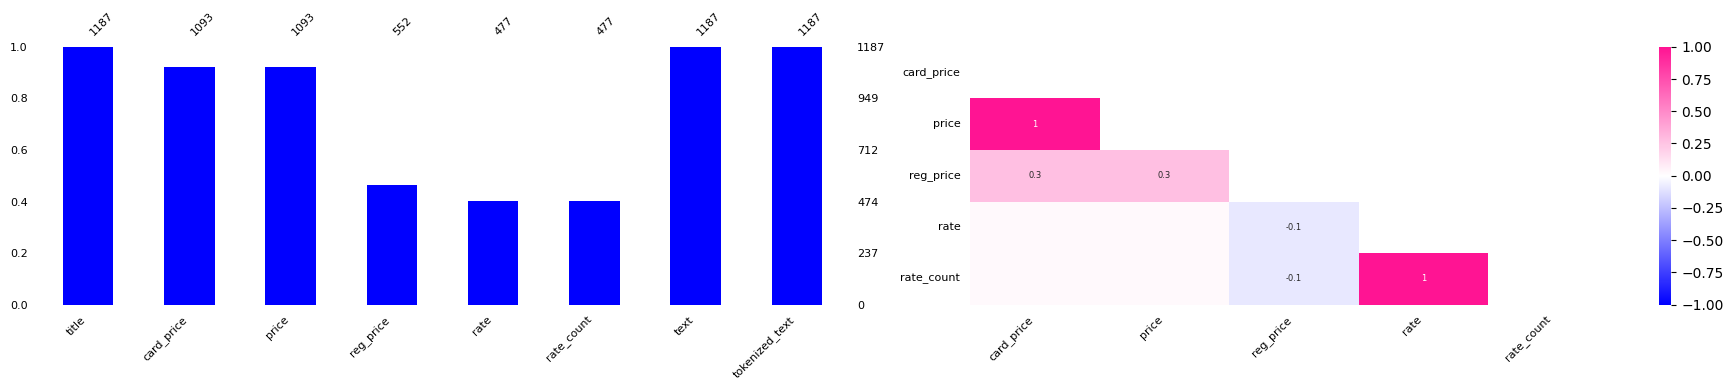

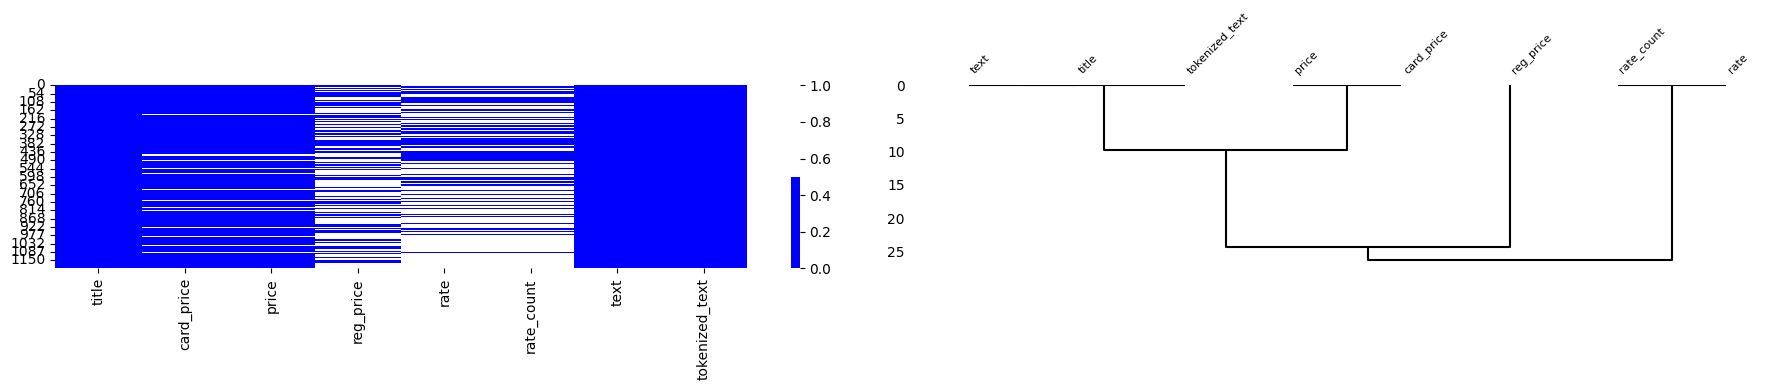

In [6]:
# Смотрим на основные столбцы (без атрибутов), их значения и зависимости
df_to_analize = df_ym_main # df_ym_main df_wb_main
f.describe_data(df_to_analize) 
f.describe_isna(df_to_analize, show = True)

Тип отопительного котла Количество контуров Тепловая мощность  \
count                     1054                 946               162   
unique                      23                   9               111   
top                    газовый       одноконтурный     9.30 - 24 кВт   
freq                       435                 586                10   

       Отапливаемая площадь   Управление  Установка Ступеней мощности  \
count                   710          785        272                60   
unique                  112            7          3                 7   
top                  240 м²  электронное  настенная                 3   
freq                     55          384        163                42   

       Макс. температура теплоносителя Размеры (ШхВхГ)    Вес  ...  \
count                               79             273    770  ...   
unique                               5             159    183  ...   
top                              90 °С  450x763x345 мм  31 кг  ...   
freq                                46               7     34  ...   

       Мин. температура в контуре ГВС  \
count                               1   
unique                              1   
top                             35 °С   
freq                                1   

       Номинальный ток автоматического выключателя 3Ф  \
count                                              13   
unique                                              6   
top                                              32 А   
freq                                                5   

       Производительность горячей воды при t 40°C  \
count                                          30   
unique                                         16   
top                                     8.6 л/мин   
freq                                            6   

       Производительность горячей воды при t 45°C  \
count                                           5   
unique                                          4   
top                                       4 л/мин   
freq                                            2   

       Производительность горячей воды при t 50°C Объем встроенного бойлера  \
count                                           6                        20   
unique                                          4                         7   
top                                     3.8 л/мин                       6 л   
freq                                            2                        10   

       Производительность горячей воды при t 20°C  \
count                                           8   
unique                                          7   
top                                     3.8 л/мин   
freq                                            2   

       Макс. температура в контуре ГВС Битермический теплообменник  \
count                                1                           7   
unique                               1                           1   
top                              64 °С                        есть   
freq                                 1                           7   

       Принцип работы на твердом топливе  
count                                  1  
unique                                 1  
top                         классический  
freq                                   1  

[4 rows x 92 columns]

shape (1187, 92)
size 109204
isna 86657
isna share 79.35%


dtype  size  isna isna_share
Тип отопительного котла                     object  1054   133     11.20%
Количество контуров                         object   946   241     20.30%
Тепловая мощность                           object   162  1025     86.35%
Отапливаемая площадь                        object   710   477     40.19%
Управление                                  object   785   402     33.87%
...                                            ...   ...   ...        ...
Объем встроенного бойлера                   object    20  1167     98.32%
Производительность горячей воды при t 20°C  object     8  1179     99.33%
Макс. температура в контуре ГВС             object     1  1186     99.92%
Битермический теплообменник                 object     7  1180     99.41%
Принцип работы на твердом топливе           object     1  1186     99.92%

[92 rows x 4 columns]

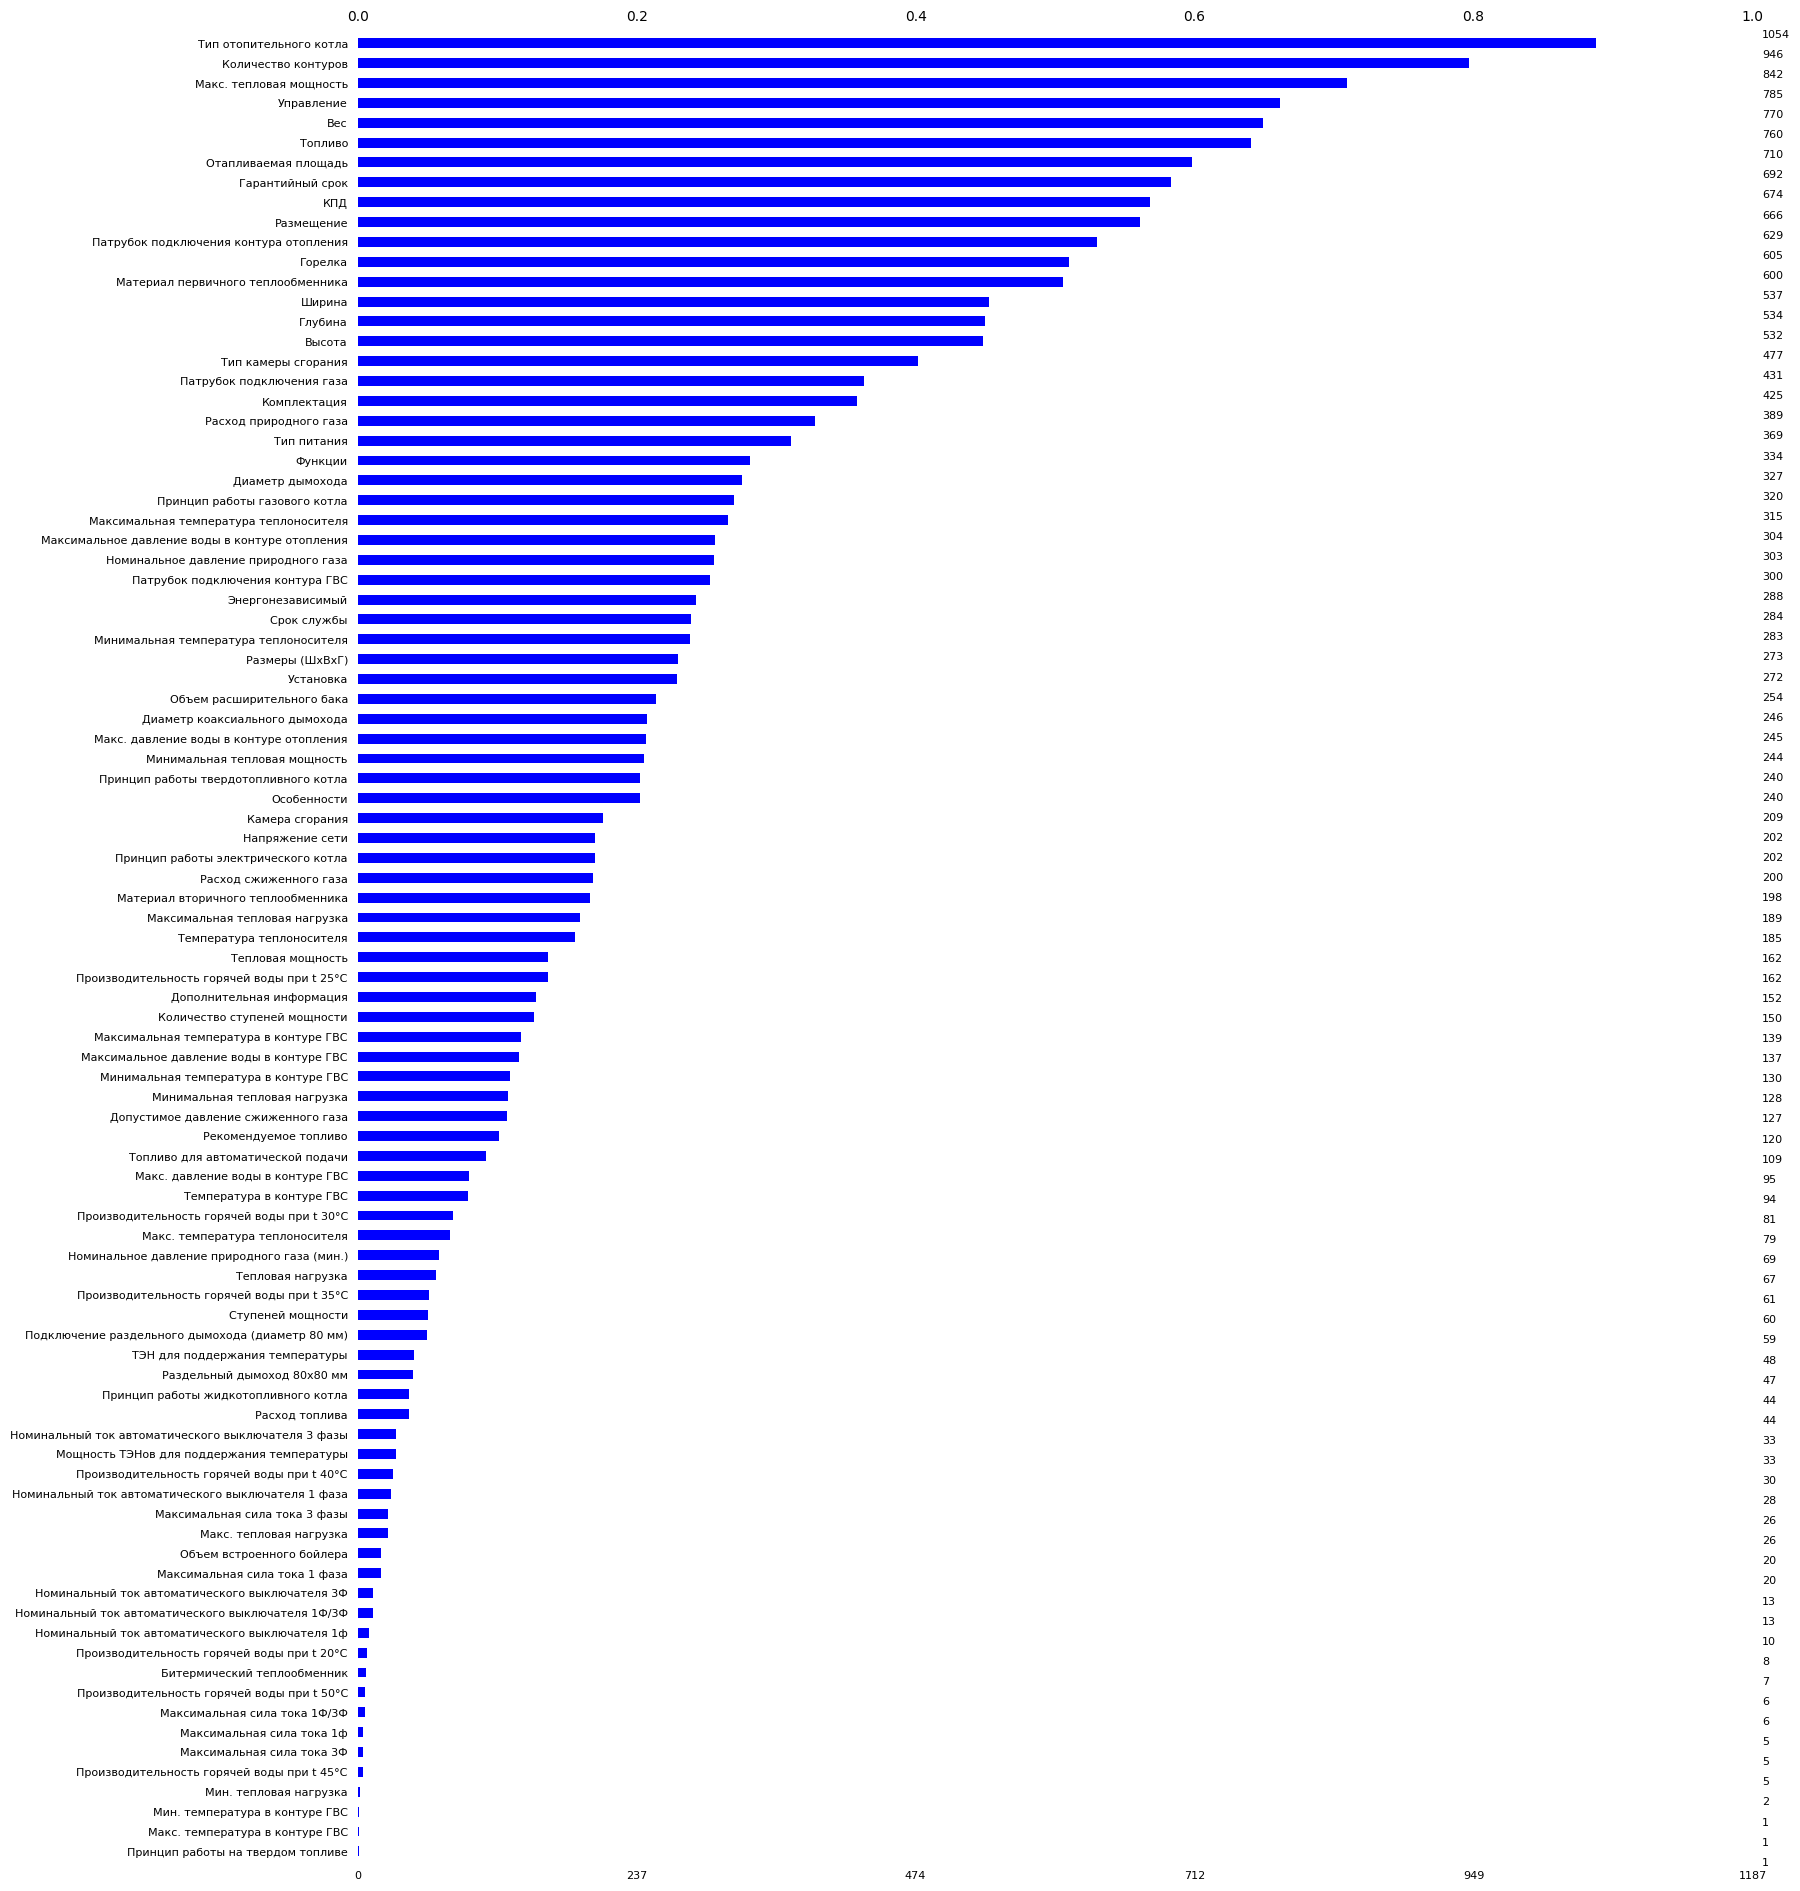

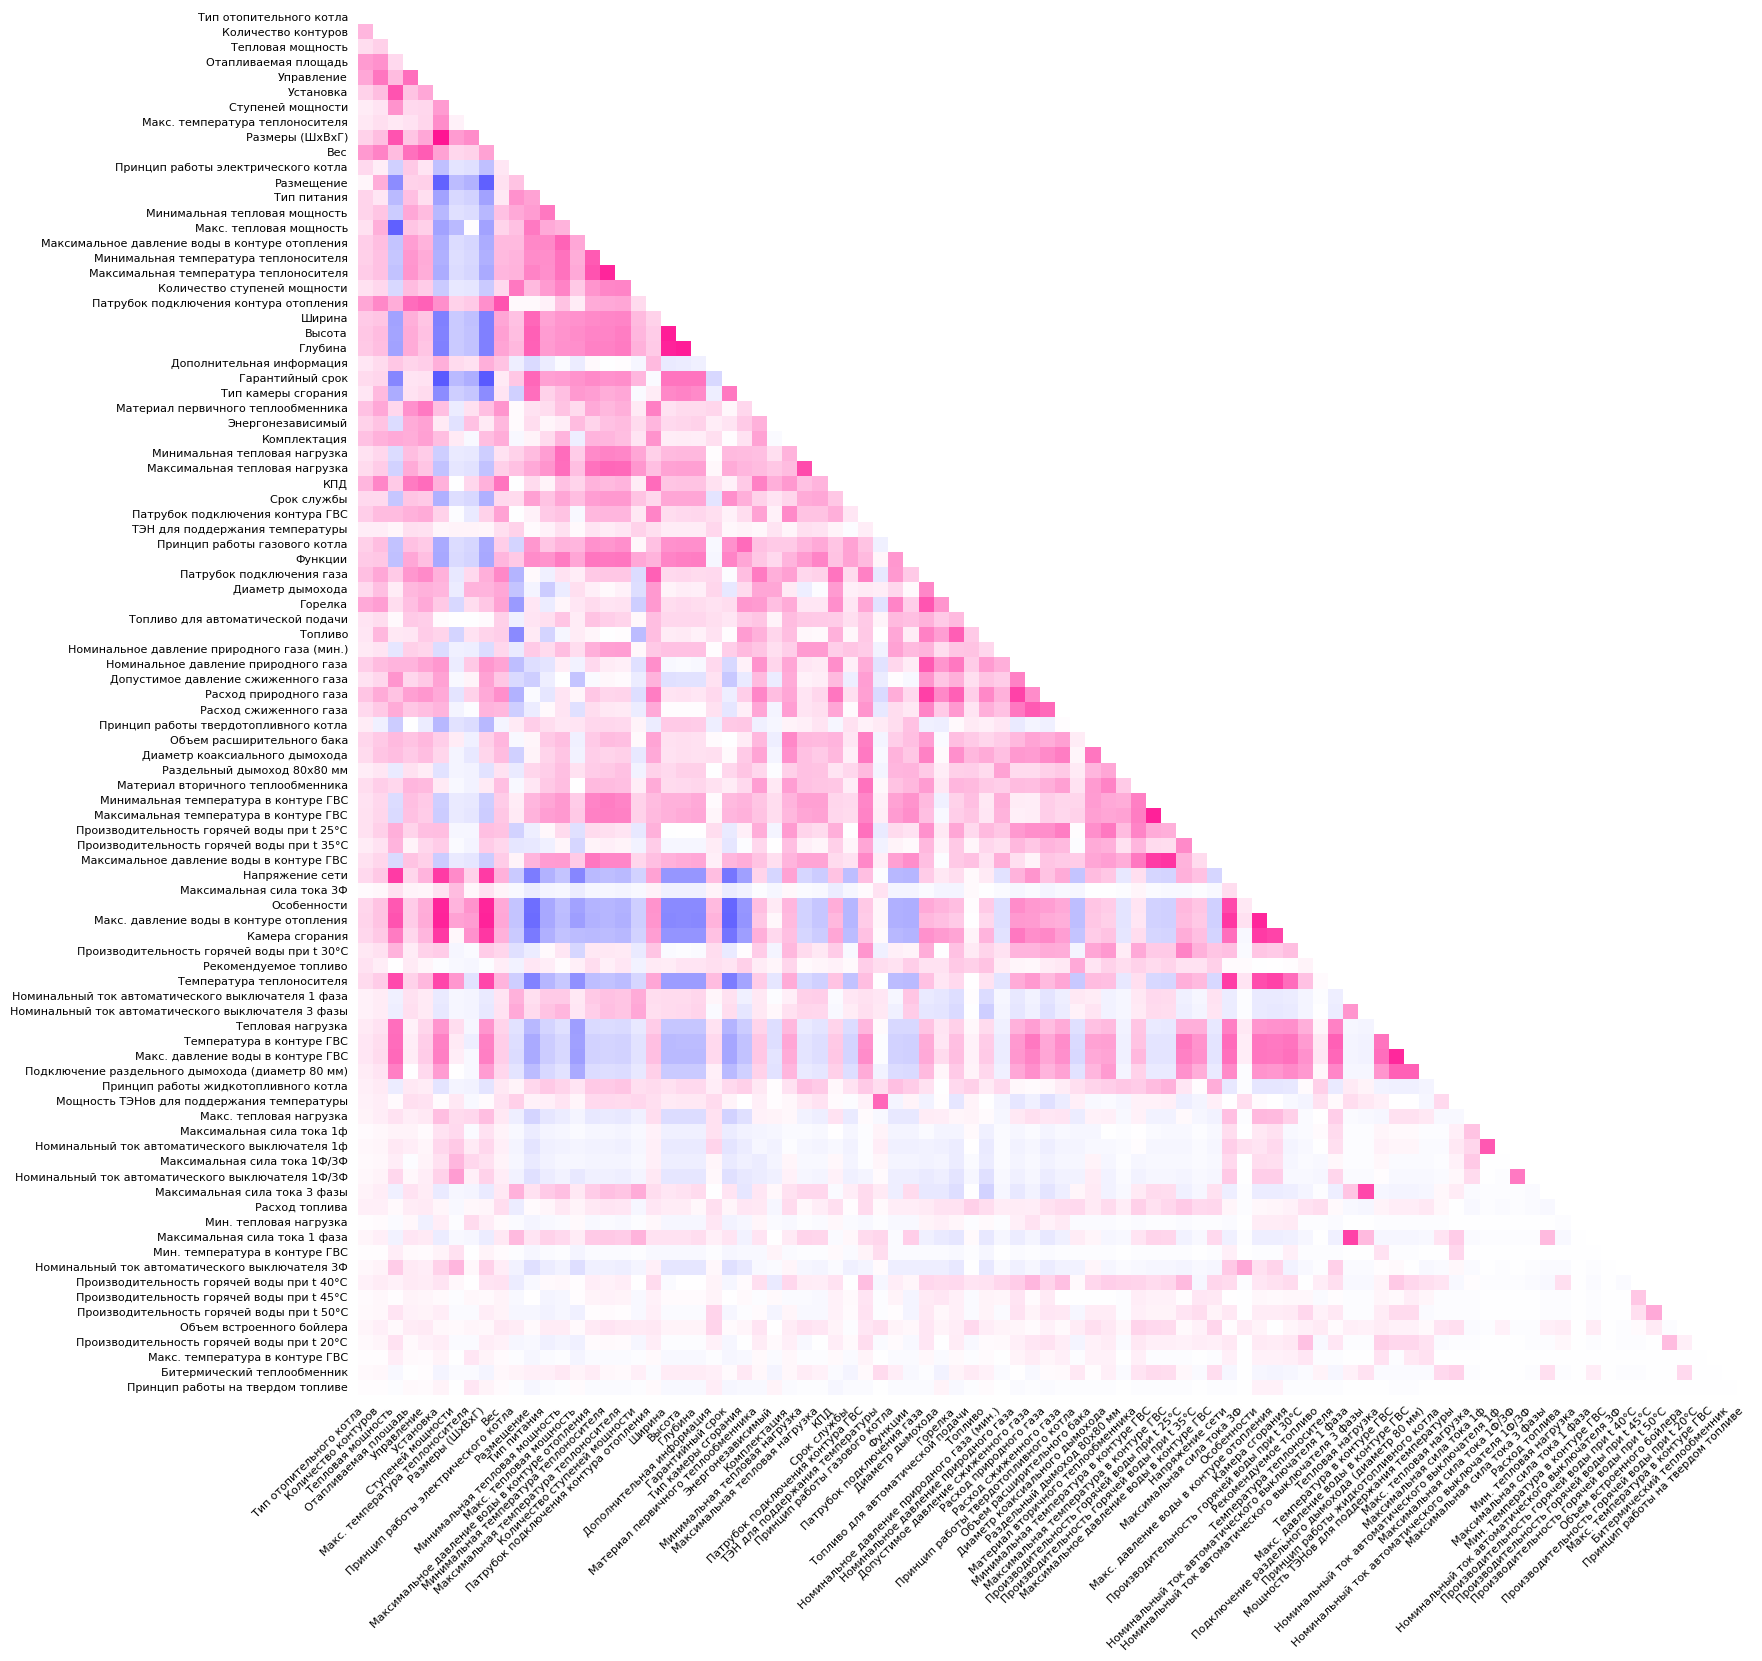

In [7]:
# Смотрим столбцы с атрибутами, их значения и зависимости
df_to_analize = df_ym_attr # df_ym_attr df_wb_attr
f.describe_data(df_to_analize) 
f.describe_isna(df_to_analize, show = True, format = 'big')

##### Фильтрация на основе текстовых данных

* <b>Фильтрация по наименованиям товаров</b>. Фильтруем данные с помощью регулярных выражений по текстам наименования товара для соответствия тематике анализа (тема "Отопительные котлы")
* <b>Проверка фильтрации</b>. Проверяем соответствие тектов нужным темам с помощью LDA модели

In [8]:
# Получаем датафреймы с целевыми товарами и токены для проверки
df_ym, df_ym_false = f.get_filtered_df(df_ym, 'title', r'кот.л|котлы|эвп')
df_wb, df_wb_false = f.get_filtered_df(df_wb, 'title', r'кот.л|котлы|эвп')

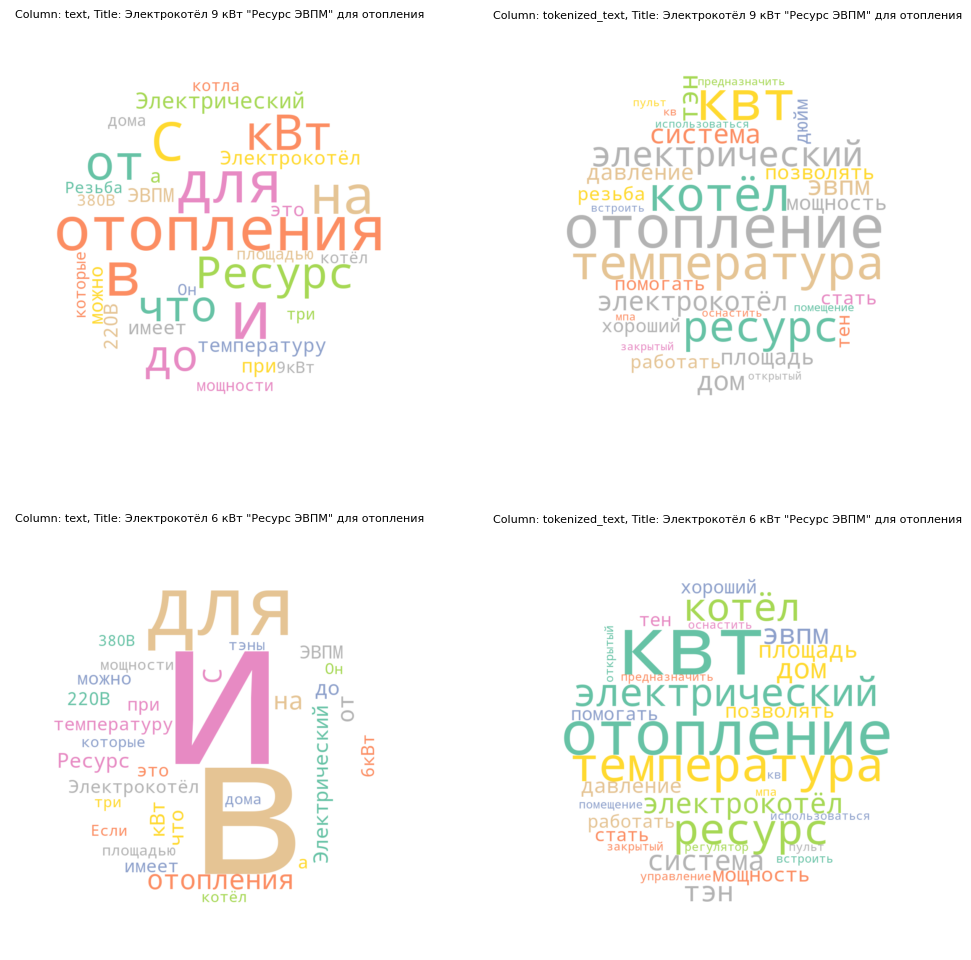

In [9]:
# Просмотр текста и токенов текста
f.show_wordcloud(df_wb[:2], ['text', 'tokenized_text'], by_row = True) # df_ym df_wb

In [10]:
# Выделяем колонки с токенами
text_ym = df_ym['tokenized_text']
text_wb = df_wb['tokenized_text']

text_ym_false = df_ym_false['tokenized_text']
text_wb_false = df_wb_false['tokenized_text']

# Проверяем соответствие тектов нужным темам с помощью LDA модели (обычно достаточно 5-6 тем)
print('Данные соответствуют темам')
for col in [text_ym, text_wb]:
    df_topic_weights, df_doc_topic_weights = f.get_topic_weight(col, 6)
    display(df_topic_weights)

# Проверяем удаленные данные на несоответствие нужным темам
print('Данные на исключение')
for col in [text_ym_false, text_wb_false]:
    df_topic_weights, df_doc_topic_weights = f.get_topic_weight(col, 6)
    display(df_topic_weights)

Данные соответствуют темам


topic_0                       topic_1  \
0         (котёл, 0.020965884)          (котёл, 0.039359916)   
1   (температура, 0.015981881)     (отопление, 0.0132514695)   
2     (отопление, 0.014979046)        (система, 0.013225408)   
3       (система, 0.012794704)         (работа, 0.009285105)   
4             (3, 0.010356581)  (теплообменник, 0.009230257)   
5          (вода, 0.009164179)    (температура, 0.009190844)   
6  (теплоноситель, 0.00895093)        (газовый, 0.009127768)   
7     (помещение, 0.008334597)            (газ, 0.008405524)   
8           (квт, 0.008330695)              (3, 0.007829125)   
9      (давление, 0.007984664)       (мощность, 0.007276635)   

                         topic_2                     topic_3  \
0           (котёл, 0.043605246)        (котёл, 0.031168258)   
1        (система, 0.0137932375)  (температура, 0.010783452)   
2     (температура, 0.013196975)    (управление, 0.01003225)   
3        (отопление, 0.01148819)      (система, 0.009439041)   
4      (управление, 0.011170121)    (отопление, 0.009223291)   
5        (газовый, 0.0076979566)     (мощность, 0.008479824)   
6         (работа, 0.0068893936)            (3, 0.008445571)   
7  (теплоноситель, 0.0068653952)  (подключение, 0.008069021)   
8   (теплообменник, 0.006691256)     (газовый, 0.0072866306)   
9      (помещение, 0.0064032795)   (позволять, 0.0071215364)   

                      topic_4                       topic_5  
0        (котёл, 0.024996199)          (котёл, 0.032508142)  
1    (отопление, 0.013681006)      (отопление, 0.015117953)  
2      (система, 0.012041911)        (система, 0.011835116)  
3  (управление, 0.0111270165)     (управление, 0.008135732)  
4  (температура, 0.008442935)  (теплообменник, 0.007675758)  
5     (мощность, 0.007857379)        (работа, 0.0076017696)  
6   (помещение, 0.0076640374)   (температура, 0.0070282584)  
7       (насос, 0.0073305694)     (позволять, 0.0067889737)  
8  (подключение, 0.006857857)            (квт, 0.005884055)  
9          (квт, 0.006433471)       (газовый, 0.0056329165)

topic_0                       topic_1  \
0          (котёл, 0.033861578)          (котёл, 0.035960626)   
1      (отопление, 0.019754767)    (температура, 0.024136826)   
2      (управление, 0.01245037)      (отопление, 0.023303991)   
3    (температура, 0.012442399)      (помещение, 0.016459474)   
4      (помещение, 0.010586569)    (управление, 0.0155328745)   
5       (мощность, 0.010301989)        (система, 0.013094798)   
6  (теплоноситель, 0.009804123)   (электрокотёл, 0.012289073)   
7         (работа, 0.009688023)    (отопительный, 0.00999176)   
8            (квт, 0.009601318)              (3, 0.009647112)   
9              (5, 0.009391434)  (электрический, 0.008468176)   

                        topic_2                       topic_3  \
0           (котёл, 0.03091143)          (котёл, 0.046664547)   
1      (отопление, 0.019600185)    (температура, 0.016663244)   
2    (температура, 0.019458272)      (отопление, 0.016214246)   
3        (система, 0.017059043)      (помещение, 0.012970401)   
4            (квт, 0.014092871)  (электрический, 0.011229551)   
5  (электрический, 0.014001621)        (система, 0.009793009)   
6              (3, 0.011598776)       (мощность, 0.009394582)   
7  (теплоноситель, 0.010764136)              (1, 0.008854686)   
8      (мощность, 0.0103190895)       (позволять, 0.00866242)   
9     (управление, 0.009733245)   (электрокотёл, 0.007943869)   

                        topic_4                       topic_5  
0          (котёл, 0.033800106)          (котёл, 0.022042518)  
1      (отопление, 0.019603597)      (отопление, 0.014655741)  
2     (управление, 0.018439882)    (температура, 0.014405691)  
3     (температура, 0.01622051)            (квт, 0.012943608)  
4       (мощность, 0.011831688)              (2, 0.010476505)  
5      (помещение, 0.008668114)              (1, 0.009653212)  
6        (система, 0.008447101)      (помещение, 0.008797803)  
7            (квт, 0.007593961)              (3, 0.008787819)  
8  (отопительный, 0.0075793527)      (мощность, 0.0072305533)  
9      (позволять, 0.007416455)  (теплоноситель, 0.006830481)

Данные на исключение


topic_0                  topic_1                topic_2  \
0        (котёл, 0.010267172)    (горелка, 0.03502323)       (2, 0.058377016)   
1      (система, 0.009303393)         (1, 0.017584879)     (vuw, 0.049863175)   
2  (температура, 0.007712825)         (x, 0.016055698)        (3, 0.03572206)   
3       (насос, 0.0072880103)       (газ, 0.014751631)       (5, 0.035623997)   
4            (2, 0.006703332)  (давление, 0.013403169)       (r, 0.025404075)   
5   (управление, 0.006301611)  (основной, 0.012855039)    (котёл, 0.01976085)   
6           (1, 0.0062375152)       (100, 0.011324938)       (1, 0.016494362)   
7       (серия, 0.0052714343)     (котёл, 0.011139778)     (282, 0.011001528)   
8        (режим, 0.004934939)     (розжиг, 0.01105793)     (200, 0.010591633)   
9           (3, 0.0047927243)         (w, 0.010602058)  (горелка, 0.01058366)   

                  topic_3               topic_4                   topic_5  
0         (5, 0.03171422)      (ff, 0.06140026)      (котёл, 0.023367083)  
1        (k, 0.026806287)     (24, 0.028816717)          (3, 0.013771485)  
2    (котёл, 0.022447307)     (cf, 0.013662479)          (1, 0.012201332)  
3         (3, 0.02149285)      (x, 0.013009286)          (2, 0.012179468)  
4       (vu, 0.019365812)     (15, 0.012927824)        (квт, 0.011519029)  
5       (oe, 0.010486466)  (котёл, 0.012697137)    (газовый, 0.008990459)  
6      (int, 0.010123125)     (18, 0.010871947)  (управление, 0.00833034)  
7  (deluxe, 0.0094904415)      (2, 0.010789187)          (5, 0.008084494)  
8  (coaxial, 0.009323519)      (3, 0.009843254)        (24, 0.0071277884)  
9       (24, 0.008968437)     (dh, 0.008979508)        (int, 0.006382222)

topic_0                       topic_1  \
0          (24, 0.050433915)             (24, 0.016890137)   
1           (f, 0.016927922)             (ff, 0.016229061)   
2          (ff, 0.016054293)          (котёл, 0.015624266)   
3           (cf, 0.01310919)              (k, 0.015519475)   
4       (котёл, 0.011471997)              (cf, 0.01111119)   
5           (1, 0.009351489)     (напряжение, 0.010236492)   
6           (2, 0.009271404)        (navien, 0.0087458175)   
7          (28, 0.008892813)             (35, 0.007951428)   
8      (работа, 0.008862899)              (2, 0.007942421)   
9  (напряжение, 0.008722682)  (отопительный, 0.0077513685)   

                  topic_2                      topic_3  \
0     (котёл, 0.03795358)             (3, 0.027473152)   
1         (k, 0.03497278)             (1, 0.022123074)   
2   (navien, 0.022495996)           (vuw, 0.016901309)   
3       (24, 0.019136729)             (2, 0.016605062)   
4       (li, 0.018552244)             (5, 0.015418946)   
5   (deluxe, 0.016942047)            (24, 0.012026559)   
6     (эван, 0.010678234)         (котёл, 0.011779518)   
7  (система, 0.008242909)          (slim, 0.008042722)   
8       (13, 0.008006976)     (напряжение, 0.00787181)   
9  (клапан, 0.0074340864)  (температура, 0.0058681853)   

                        topic_4                      topic_5  
0          (котёл, 0.027770266)          (котёл, 0.03805019)  
1     (напряжение, 0.019455314)           (эван, 0.02247916)  
2   (стабилизатор, 0.010314969)             (5, 0.018287899)  
3            (эван, 0.01021446)             (3, 0.016532438)  
4         (работа, 0.008121566)        (warmos, 0.012616414)  
5         (navien, 0.007944389)  (оригинальный, 0.009881715)  
6  (отопительный, 0.0076294583)           (тэн, 0.009174106)  
7        (система, 0.006934305)  (отопительный, 0.008718027)  
8        (газовый, 0.006882292)    (напряжение, 0.008637287)  
9            (квт, 0.006657999)            (24, 0.008270538)

In [12]:
# Пример проверки данных на исключение
df_topic_weights, df_doc_topic_weights = f.get_topic_weight(text_wb_false, 6)
df_topic_weights

topic_0                    topic_1  \
0      (котёл, 0.036543902)          (24, 0.019147454)   
1         (24, 0.022810113)       (котёл, 0.018336909)   
2        (эван, 0.01386103)           (3, 0.017483376)   
3         (ff, 0.013412778)          (ff, 0.016130596)   
4        (тэн, 0.011938001)          (30, 0.011196127)   
5          (1, 0.011843125)  (напряжение, 0.010144305)   
6          (5, 0.010812503)         (cf, 0.0098067615)   
7       (блок, 0.008153759)           (1, 0.009313301)   
8    (warmos, 0.0073571075)           (f, 0.008817867)   
9  (universal, 0.007348063)        (эван, 0.008214436)   

                       topic_2                       topic_3  \
0          (котёл, 0.03511008)          (котёл, 0.022541685)   
1        (navien, 0.024241736)      (напряжение, 0.02147514)   
2            (li, 0.021021636)   (стабилизатор, 0.011563279)   
3        (deluxe, 0.013736433)        (система, 0.009133373)   
4             (k, 0.012939671)         (работа, 0.008323128)   
5            (24, 0.012207067)            (24, 0.0072563803)   
6           (ace, 0.009868444)              (1, 0.006846384)   
7  (отопительный, 0.009734603)         (navien, 0.006624214)   
8           (эпо, 0.007869085)          (эван, 0.0066150934)   
9       (система, 0.007639309)  (оборудование, 0.0065256427)   

                       topic_4               topic_5  
0            (24, 0.025539836)     (24, 0.029093722)  
1             (5, 0.022143034)      (k, 0.027677119)  
2             (3, 0.014563407)  (котёл, 0.021266496)  
3             (1, 0.014412011)      (3, 0.018361475)  
4             (2, 0.014161367)      (1, 0.011997522)  
5    (напряжение, 0.012587823)   (эван, 0.011987616)  
6         (котёл, 0.011696437)      (2, 0.011373611)  
7           (vuw, 0.010305147)    (vuw, 0.008846111)  
8             (f, 0.008721108)     (cf, 0.008466516)  
9  (стабилизатор, 0.008483939)     (13, 0.007898983)

In [13]:
# Выделяем тему с высокими весами целевого токена и просматриваем соответствующие строки
for i_topic in ['topic_1']: # , 'topic_3', 'topic_5'
    idx = df_doc_topic_weights[~df_doc_topic_weights[i_topic].isna()].index
    display(df_wb_false[df_wb_false.index.isin(idx)][:2])

title  price  reg_price  \
2        Тэн 9 квт 2 дюйма д.59 мм для электрического котла  13600      16000   
3  Картридж трехходового клапана 60001583-01 BAXI 721403800    589        693   

   rate  rate_count  \
2   NaN           0   
3   5.0           3   

                                                                                                                                                                                                      text  \
2  Блок ТЭН 9000 Вт для электрокотла отопления, для водоногревателей (ТЭН Б) состоит из 3-х нержавеющих тэнов по 3000w, установленных на фланце с внешней резьбой 2 дюйма (59 мм), имеет трубку под дат...   
3  Картридж трехходового клапана подходит для следующего оборудования\n\nARISTON\nCLAS EVO\n24 CF\n24 FF\n28 FF\nCLAS EVO SYSTEM\n28 CF\n28 FF\nCLAS B EVO\n24 FF\n30 FF\nCLAS PREMIUM EVO\n24\n30\nCLA...   

                                                                                                                                                                                            tokenized_text  \
2  [блок, тэн, 9000, вт, электрокотёл, отопление, водоногреватель, тэн, состоять, 3, х, нержавеющий, тэновый, 3000, w, установленный, фланец, внешний, резьба, 2, дюйм, 59, трубка, датчик, температура...   
3  [картридж, трехходовой, клапан, подходить, следующий, оборудование, ariston, clas, evo, 24, cf, 24, ff, 28, ff, clas, evo, system, 28, cf, 28, ff, clas, b, evo, 24, ff, 30, ff, clas, premium, evo,...   

  Тип камеры сгорания Тип отопительного котла  \
2                 NaN           электрический   
3                 NaN           конвекционный   

  Рекомендуемая площадь помещения (кв.м)  ... Тип обогревателя  \
2                                    NaN  ...              NaN   
3                                    NaN  ...              NaN   

  Количество температурных режимов Управление Мощность устройства  \
2                              NaN        NaN                 NaN   
3                              NaN        NaN                 NaN   

  Минимальная выходная частота Длина кабеля (м) Защита от детей  \
2                          NaN              NaN             NaN   
3                          NaN              NaN             NaN   

  Степень защиты (IP) Время зарядки Инверторная технология  
2                 NaN           NaN                    NaN  
3                 NaN           NaN                    NaN  

[2 rows x 105 columns]

In [14]:
# Для удобства визуализируем данные и просматриваем кластеры слов каждой темы
common_dictionary, common_corpus = f.get_corpus(text_wb_false) # text_ym_false, text_ym, text_wb
lda_model = f.get_lda_model(common_dictionary, common_corpus, 6)
vis_data = gensimvis.prepare(lda_model, common_corpus, common_dictionary) # подготовка объекта визуальных данных по пространству тем
pyLDAvis.display(vis_data) # визуализируем данные

In [15]:
print('Исходная форма данных')
print('Яндекс.Маркет',df_ym_input.shape)
print('Wildberries', df_wb_input.shape)
print('Форма данных после фильтрации по наименованиям')
print('Яндекс.Маркет', df_ym.shape)
print('Wildberries', df_wb.shape)

Исходная форма данных
Яндекс.Маркет (1187, 101)
Wildberries (1310, 105)
Форма данных после фильтрации по наименованиям
Яндекс.Маркет (1035, 101)
Wildberries (463, 105)


##### Фильтрация на основе нумерических данных

* <b>Проверка на заполненность данных</b>. Проверяем столбцы на заполненность данных, выводим данные и графики
* <b>Проверка на значимость незаполненных данных</b>. Анализируем природу отсутствующих значений
* <b>Удаление малозаполненных данных</b>. Удаляем столбцы, где мало данных для анализа
* <b>Проверка на нормальность данных</b>. Тестируем данные на нормальность, проверяем смещение, эксцесс, дисперсию и среднее
* <b>Проверка на выбросы</b>. Просматриваем выбросы с помощью отрезания квантилей и сигм
* <b>Определение кандидатов на исключение</b>. Определяем соответствие тематике кандидатов на исключение
* <b>Нормализация данных</b>. Приводим данные к нормальному распределению выбранным методом
* <b>Масштабирование и стандартизация данных</b>. Применяем каскадное нормирование данных (StandartScaler -> MinMaxScaler) для выравнивания значений в столбцах и приведения к диапазону 0-1

Яндекс.Маркет - количество карточек товара 1035


card_price    0.08
price         0.08
reg_price     0.57
rate          0.57
rate_count    0.57
dtype: float64

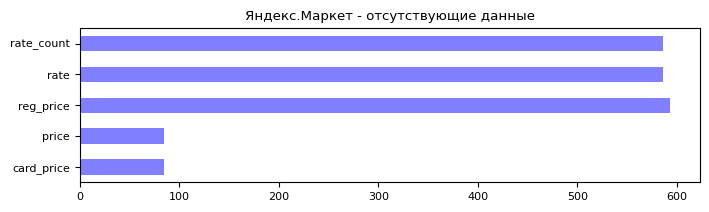

Wildberries - количество карточек товара 463


price         0.00
reg_price     0.00
rate          0.47
rate_count    0.47
dtype: float64

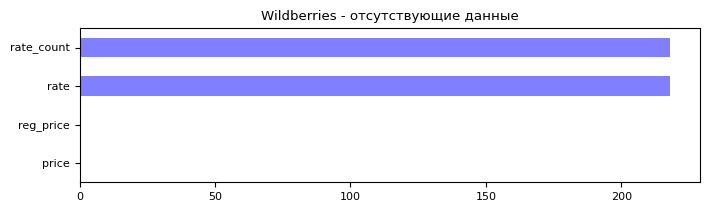

In [16]:
# Проверяем столбцы на заполненность данных
dict_df = {'Яндекс.Маркет' : df_ym, 'Wildberries' : df_wb}
for df_key in dict_df.keys():
    num_col = list(dict_df[df_key].select_dtypes(include=['int', 'float']).columns)
    dict_df[df_key]['rate_count'] = dict_df[df_key]['rate_count'].replace({0:np.nan})
    print(f'{df_key} - количество карточек товара', len(dict_df[df_key]))
    display((dict_df[df_key][num_col].isnull().sum() / len(dict_df[df_key])).round(2))
    plt.rcParams['font.size'] = 8
    (dict_df[df_key][num_col].isnull().sum()).plot.barh(figsize=(8,2), color = 'b', alpha = .5) #.sort_values(ascending = False)
    plt.title(f'{df_key} - отсутствующие данные')
    plt.show()

При отсутствующей цене, отсутствуют значения в столбцах card_price и reg_price, возможно товар удален из Яндекс.Маркет и информация по нему не актуальна

In [17]:
# Удаляем пустые строки с ценой
print(df_ym[df_ym['price'].isna()][['card_price', 'price', 'reg_price']].isnull().all().all()) # проверяем зависимость пустых значений
df_ym = df_ym.dropna(subset=['price'])

True


In [18]:
# Удаляем столбцы, где мало данных для анализа
df_wb = df_wb.drop(columns=['rate', 'rate_count'], axis = 1)
df_ym = df_ym.drop(columns=['reg_price', 'rate', 'rate_count'], axis = 1)

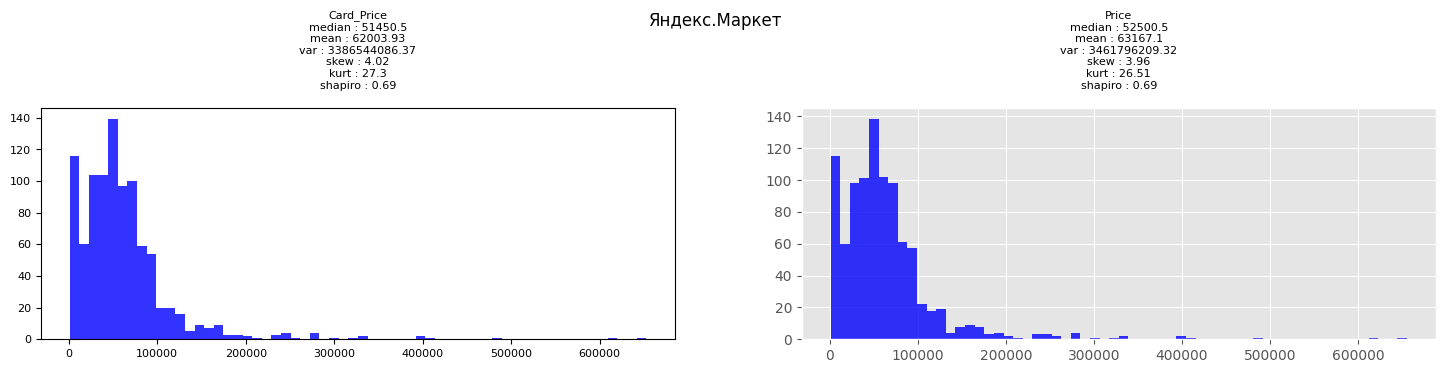

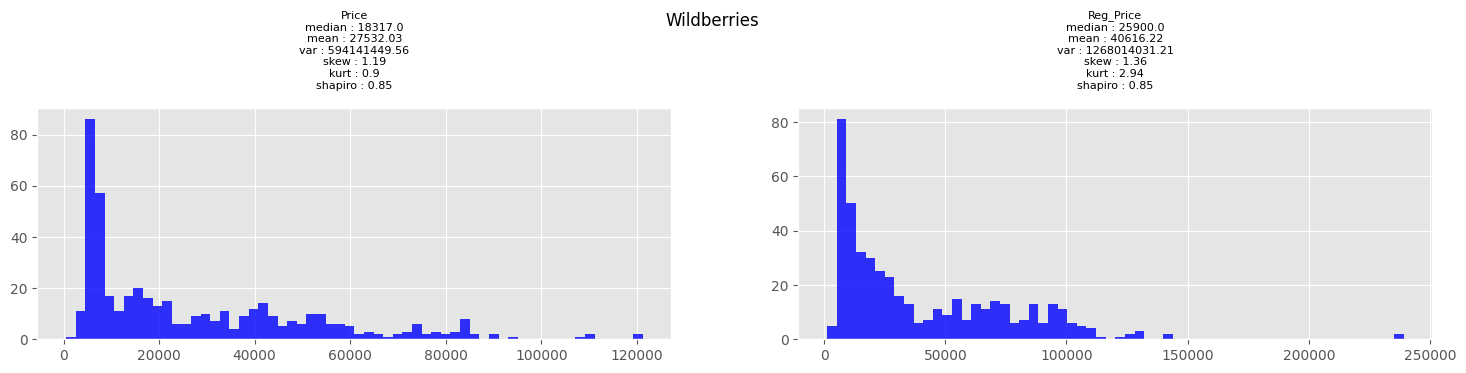

In [19]:
# Смотрим на статистики нумерических столбцов
dict_df = {'Яндекс.Маркет' : df_ym, 'Wildberries' : df_wb}
for df_key in dict_df.keys():
    num_col = list(dict_df[df_key].select_dtypes(include='number').columns) #['int', 'float']
    plt.figure(figsize = (18, 3))
    plt.suptitle(f'{df_key}', y=1.2, fontsize=12)
    for i, col in enumerate(dict_df[df_key][num_col]):
        plt.subplot(1, len(num_col), i + 1)
        f.analyze(dict_df[df_key][col])
    plt.show()

На графиках данные смещены влево и по тесту Шапиро-Уилка значение меньше 0.95, значит данные требуют проверки и нормализации

sequence: ['price', 'reg_price']
----------------------------------------------------------------------
before sequence: 463
	Price: min-max [540, 121210]
	Reg_price: min-max [1200, 239105]
----------------------------------------------------------------------
after applying quantile(0.999) to price: 462
after applying quantile(0.999) to reg_price: 461
	Price: min-max [540, 119829]
	Reg_price: min-max [1200, 235708]
----------------------------------------------------------------------
after applying sigma(3) to price: 457
	Price: min-max [540, 94435]
	Reg_price: min-max [1200, 235708]
----------------------------------------------------------------------
after applying sigma(3) to reg_price: 456
	Price: min-max [540, 94435]
	Reg_price: min-max [1200, 130625]
----------------------------------------------------------------------
after sequence: 456
outliers count: 7



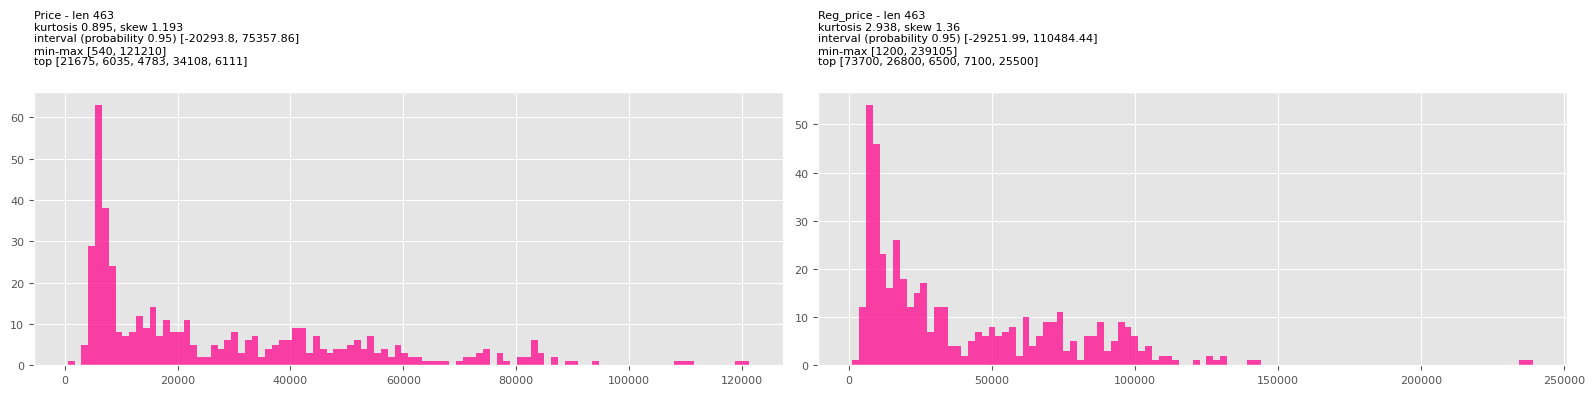

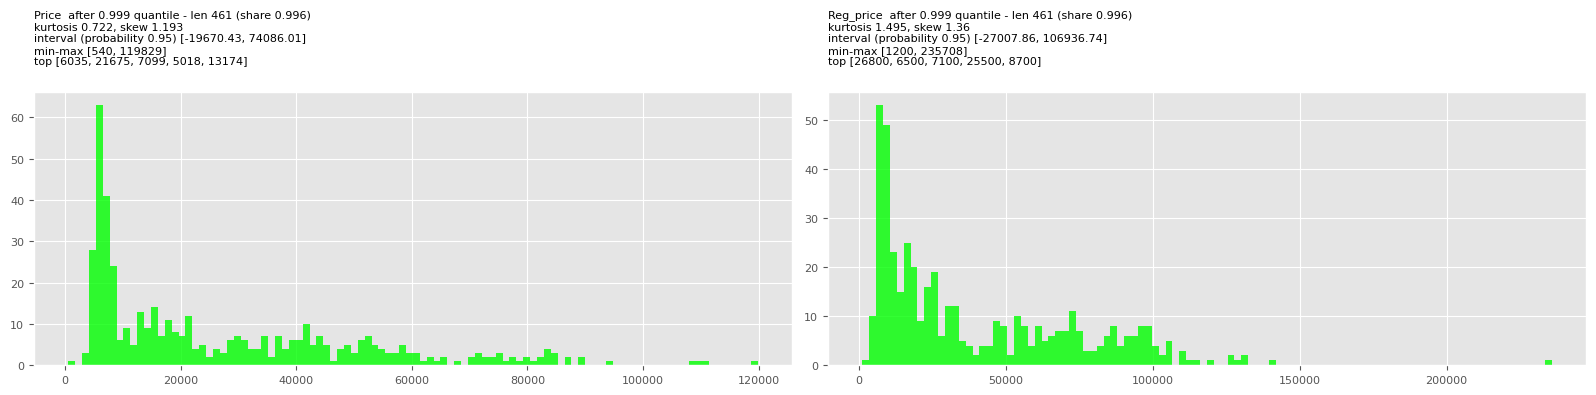

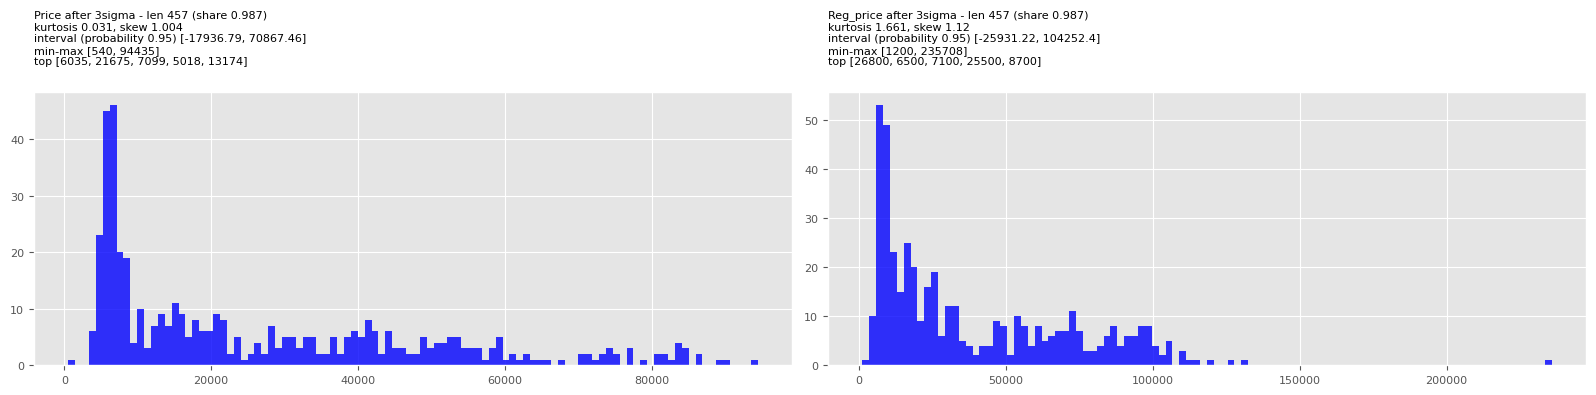

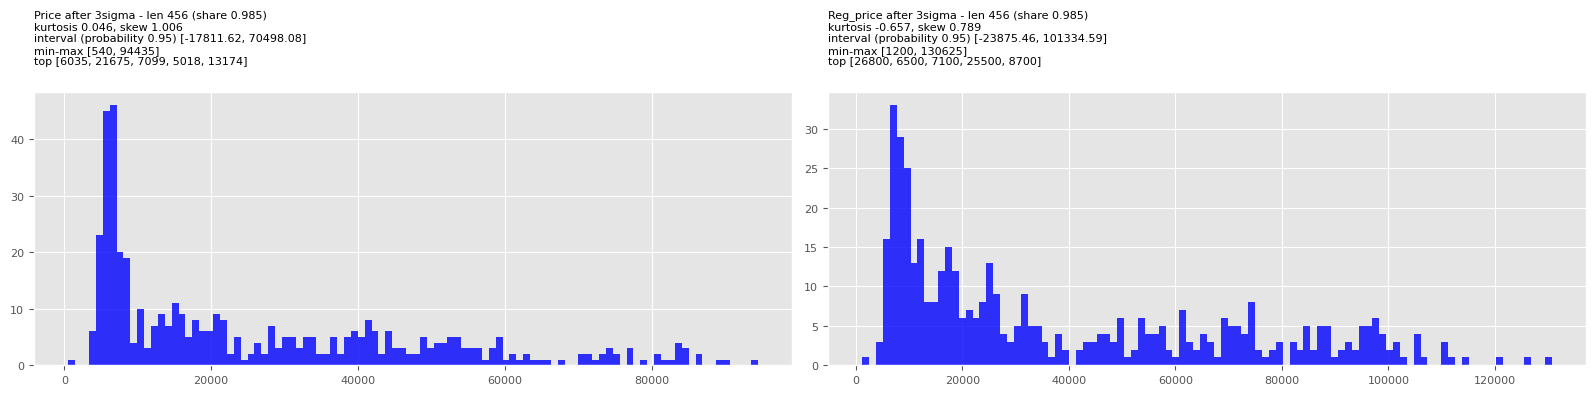

In [20]:
# Сначала проверяем данные на предмет выбросов (df_outliers), предварительно задав параметры нужные функции
df_to_analyze = df_wb # df_ym df_wb
cols = list(df_to_analyze.select_dtypes(include='number').columns)
df_norm, df_outliers = f.apply_quantile_sigma_sequence(df_to_analyze, quantile = .999, sigma = 3, how = 'both', interval = 0.95, seq_columns = cols, apply_quantile = True)
# display(df_outliers)

Проверка данных показала, что выбросов (шума) нет, но есть аномалии в ценах, особенно в Яндекс.Маркет
Так как асимметрия более .75 по модулю и все данные имеют значимость, требуется приведение к нормальному распределению для дальнейшей обработки данных.

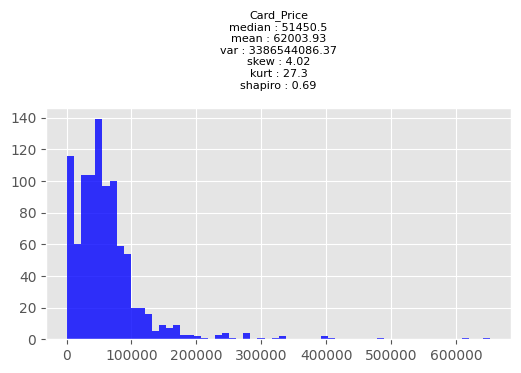

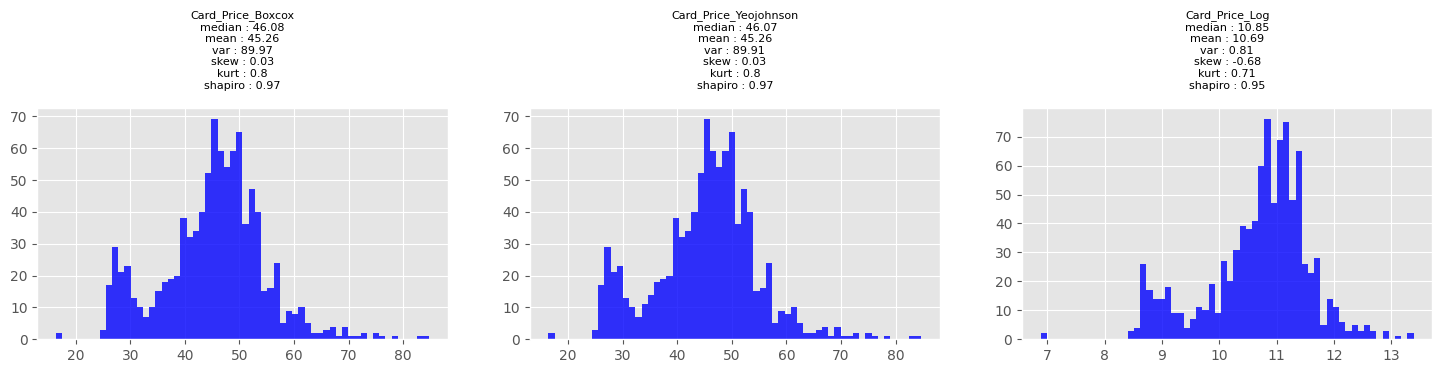

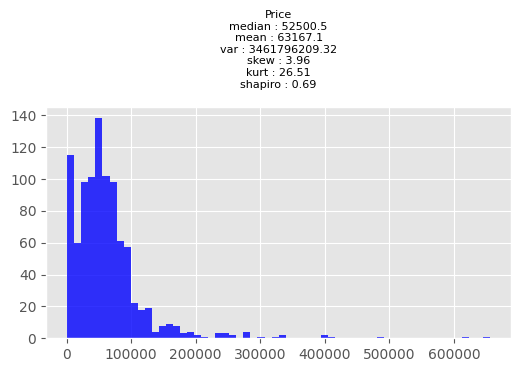

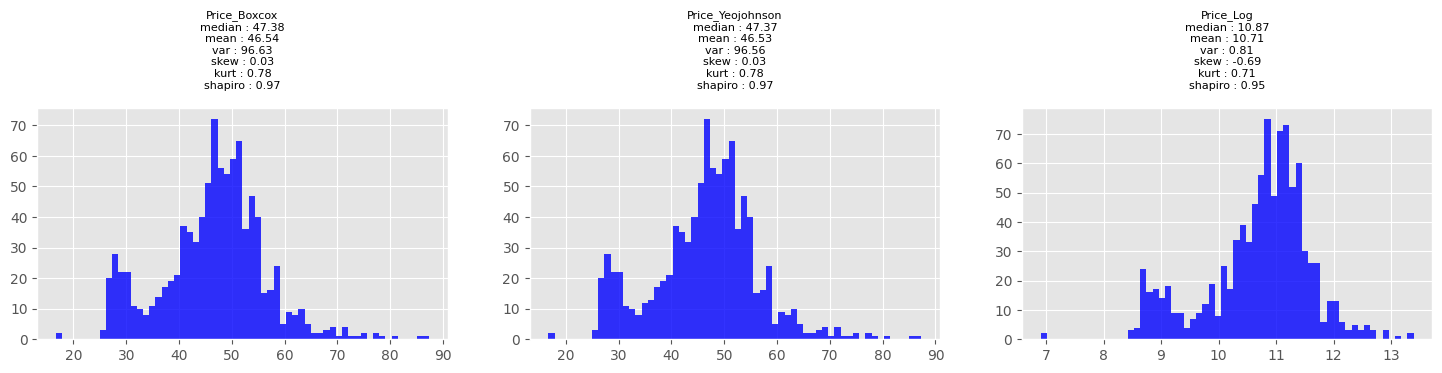

In [21]:
# Оцениваем разные способы преобразования: 'box-cox', 'yeo-johnson', логарифмирование
df_to_analyze = df_ym # df_ym df_wb
for col in df_to_analyze[list(df_to_analyze.select_dtypes(include='number').columns)]:
    f.norm_num(df_to_analyze, col, methods = [], inplace = False)

In [22]:
# Cоздаем дополнительные столбцы с нормализованными данными выбранным методом
for col in df_ym[list(df_ym.select_dtypes(include='number').columns)]:
    f.norm_num(df_ym, col, methods = ['yeo-johnson'], inplace = True, quite = True)

for col in df_wb[list(df_wb.select_dtypes(include='number').columns)]:
    f.norm_num(df_wb, col, methods = ['yeo-johnson'], inplace = True, quite = True)

In [23]:
# Применяем каскадное нормирование данных (StandartScaler -> MinMaxScaler) для выравнивания значений в столбцах и приведения к диапазону 0-1
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler_s = StandardScaler()
scaler_m = MinMaxScaler()

df_ym.loc[:, df_ym.columns.str.contains('yeojohnson')] = scaler_s.fit_transform(df_ym.loc[:, df_ym.columns.str.contains('yeojohnson')])
df_ym.loc[:, df_ym.columns.str.contains('yeojohnson')] = scaler_m.fit_transform(df_ym.loc[:, df_ym.columns.str.contains('yeojohnson')])

df_wb.loc[:, df_wb.columns.str.contains('yeojohnson')] = scaler_s.fit_transform(df_wb.loc[:, df_wb.columns.str.contains('yeojohnson')])
df_wb.loc[:, df_wb.columns.str.contains('yeojohnson')] = scaler_m.fit_transform(df_wb.loc[:, df_wb.columns.str.contains('yeojohnson')])

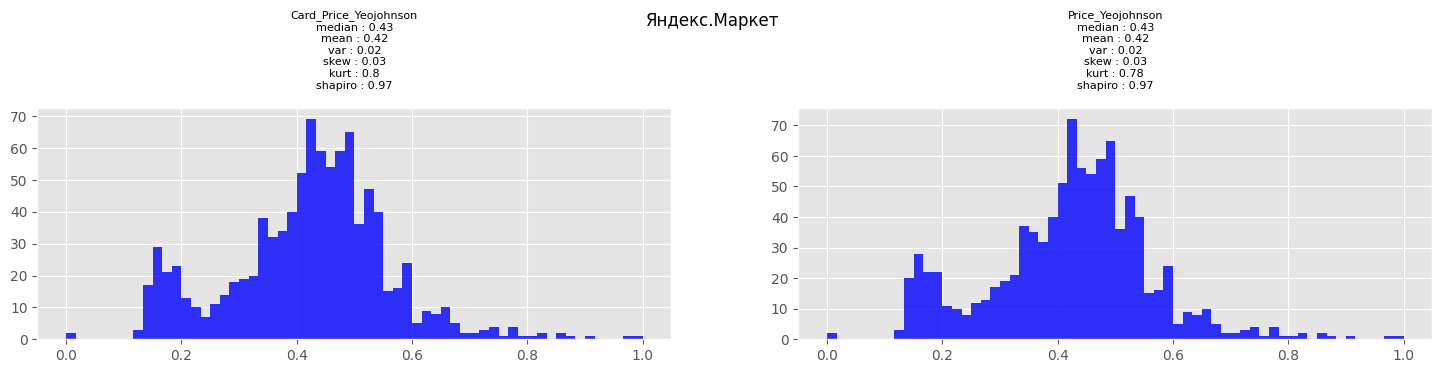

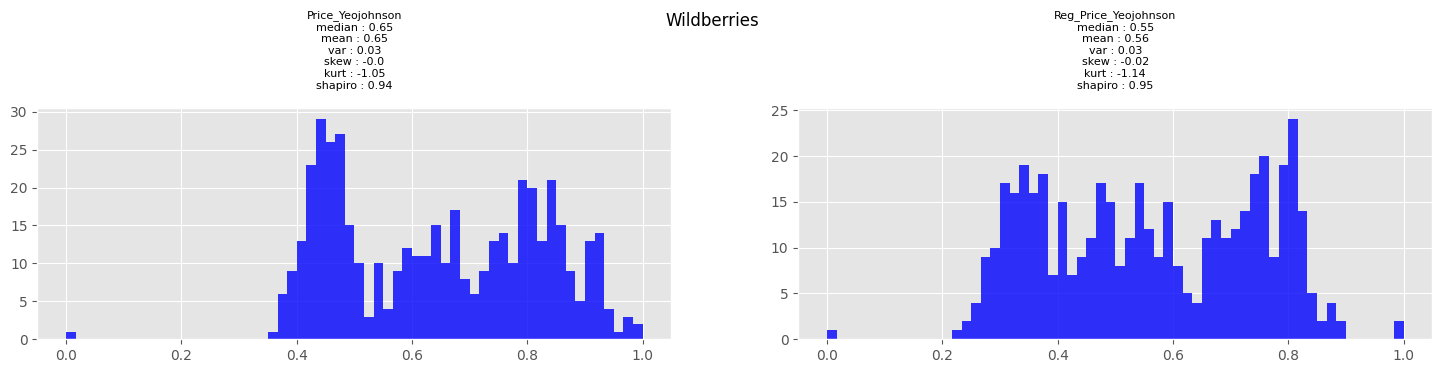

In [24]:
dict_df = {'Яндекс.Маркет' : df_ym, 'Wildberries' : df_wb}
for df_key in dict_df.keys():
    num_col = dict_df[df_key].loc[:, dict_df[df_key].columns.str.contains('yeojohnson')].columns
    plt.figure(figsize = (18, 3))
    plt.suptitle(f'{df_key}', y=1.2, fontsize=12)
    for i, col in enumerate(dict_df[df_key][num_col]):
        plt.subplot(1, len(num_col), i + 1)
        f.analyze(dict_df[df_key][col])
    plt.show()

Теперь данные числовых столбцов имеют близкое к нормальному распределение и укладываются в диапазон 0-1

In [25]:
print('Исходная форма данных')
print('Яндекс.Маркет',df_ym_input.shape)
print('Wildberries', df_wb_input.shape)
print('Форма данных после фильтрации по ценам')
print('Яндекс.Маркет', df_ym.shape)
print('Wildberries', df_wb.shape)

Исходная форма данных
Яндекс.Маркет (1187, 101)
Wildberries (1310, 105)
Форма данных после фильтрации по ценам
Яндекс.Маркет (950, 100)
Wildberries (463, 105)


В Яндекс.Маркет выборка товаров намного лучше соответствует запросу, чем в Wildberries

##### Выделение ключевых атрибутов

* <b>Удаление пустых столбцов атрибутов товара</b>. После фильтрации данных по наименованиям товаров и их метрикам атрибуты удаленных и не соответсвующих теме товаров требуется удалить
* <b>Удаление непопулярных атрибутов</b>. Выделяем ключевые атрибуты на основе заполненности их значений. Удаляем непопулярные атрибуты, где содержание na превышает порог
* <b>Визуализация данных</b>. Сравниваем графики распределения до и после выделения ключевых атрибутов, выводим облако наименований ключевых атрибутов
* <b>Анализ значений атрибутов</b>. Смотрим на топ значений в столбцах атрибутов или слов, с весами и без

In [26]:
# Выделяем столбцы с атрибутами и удаляем пустые 
cols_ym_attr = list(filter(lambda x: bool(re.match('[а-яА-Я]', x)), df_ym.columns))
df_ym_attr = df_ym[cols_ym_attr].dropna(axis=1, how='all')

cols_wb_attr = list(filter(lambda x: bool(re.match('[а-яА-Я]', x)), df_wb.columns))
df_wb_attr = df_wb[cols_wb_attr].dropna(axis=1, how='all')

# Наименования и количество атрибутов
for df in [df_ym_attr, df_wb_attr]:
    print('Columns quantity:', len(list(df.columns)))
    print('Columns:', list(df.columns))

Columns quantity: 92
Columns: ['Тип отопительного котла', 'Количество контуров', 'Тепловая мощность', 'Отапливаемая площадь', 'Управление', 'Установка', 'Ступеней мощности', 'Макс. температура теплоносителя', 'Размеры (ШхВхГ)', 'Вес', 'Принцип работы электрического котла', 'Размещение', 'Тип питания', 'Минимальная тепловая мощность', 'Макс. тепловая мощность', 'Максимальное давление воды в контуре отопления', 'Минимальная температура теплоносителя', 'Максимальная температура теплоносителя', 'Количество ступеней мощности', 'Патрубок подключения контура отопления', 'Ширина', 'Высота', 'Глубина', 'Дополнительная информация', 'Гарантийный срок', 'Тип камеры сгорания', 'Материал первичного теплообменника', 'Энергонезависимый', 'Комплектация', 'Минимальная тепловая нагрузка', 'Максимальная тепловая нагрузка', 'КПД', 'Срок службы', 'Патрубок подключения контура ГВС', 'ТЭН для поддержания температуры', 'Принцип работы газового котла', 'Функции', 'Патрубок подключения газа', 'Диаметр дымохода',

shape (950, 92)
size 87400
isna 67508
isna share 77.24%


dtype  size  isna isna_share
Тип отопительного котла                     object   870    80      8.42%
Количество контуров                         object   840   110     11.58%
Тепловая мощность                           object   147   803     84.53%
Отапливаемая площадь                        object   641   309     32.53%
Управление                                  object   705   245     25.79%
...                                            ...   ...   ...        ...
Объем встроенного бойлера                   object    17   933     98.21%
Производительность горячей воды при t 20°C  object     7   943     99.26%
Макс. температура в контуре ГВС             object     1   949     99.89%
Битермический теплообменник                 object     6   944     99.37%
Принцип работы на твердом топливе           object     1   949     99.89%

[92 rows x 4 columns]

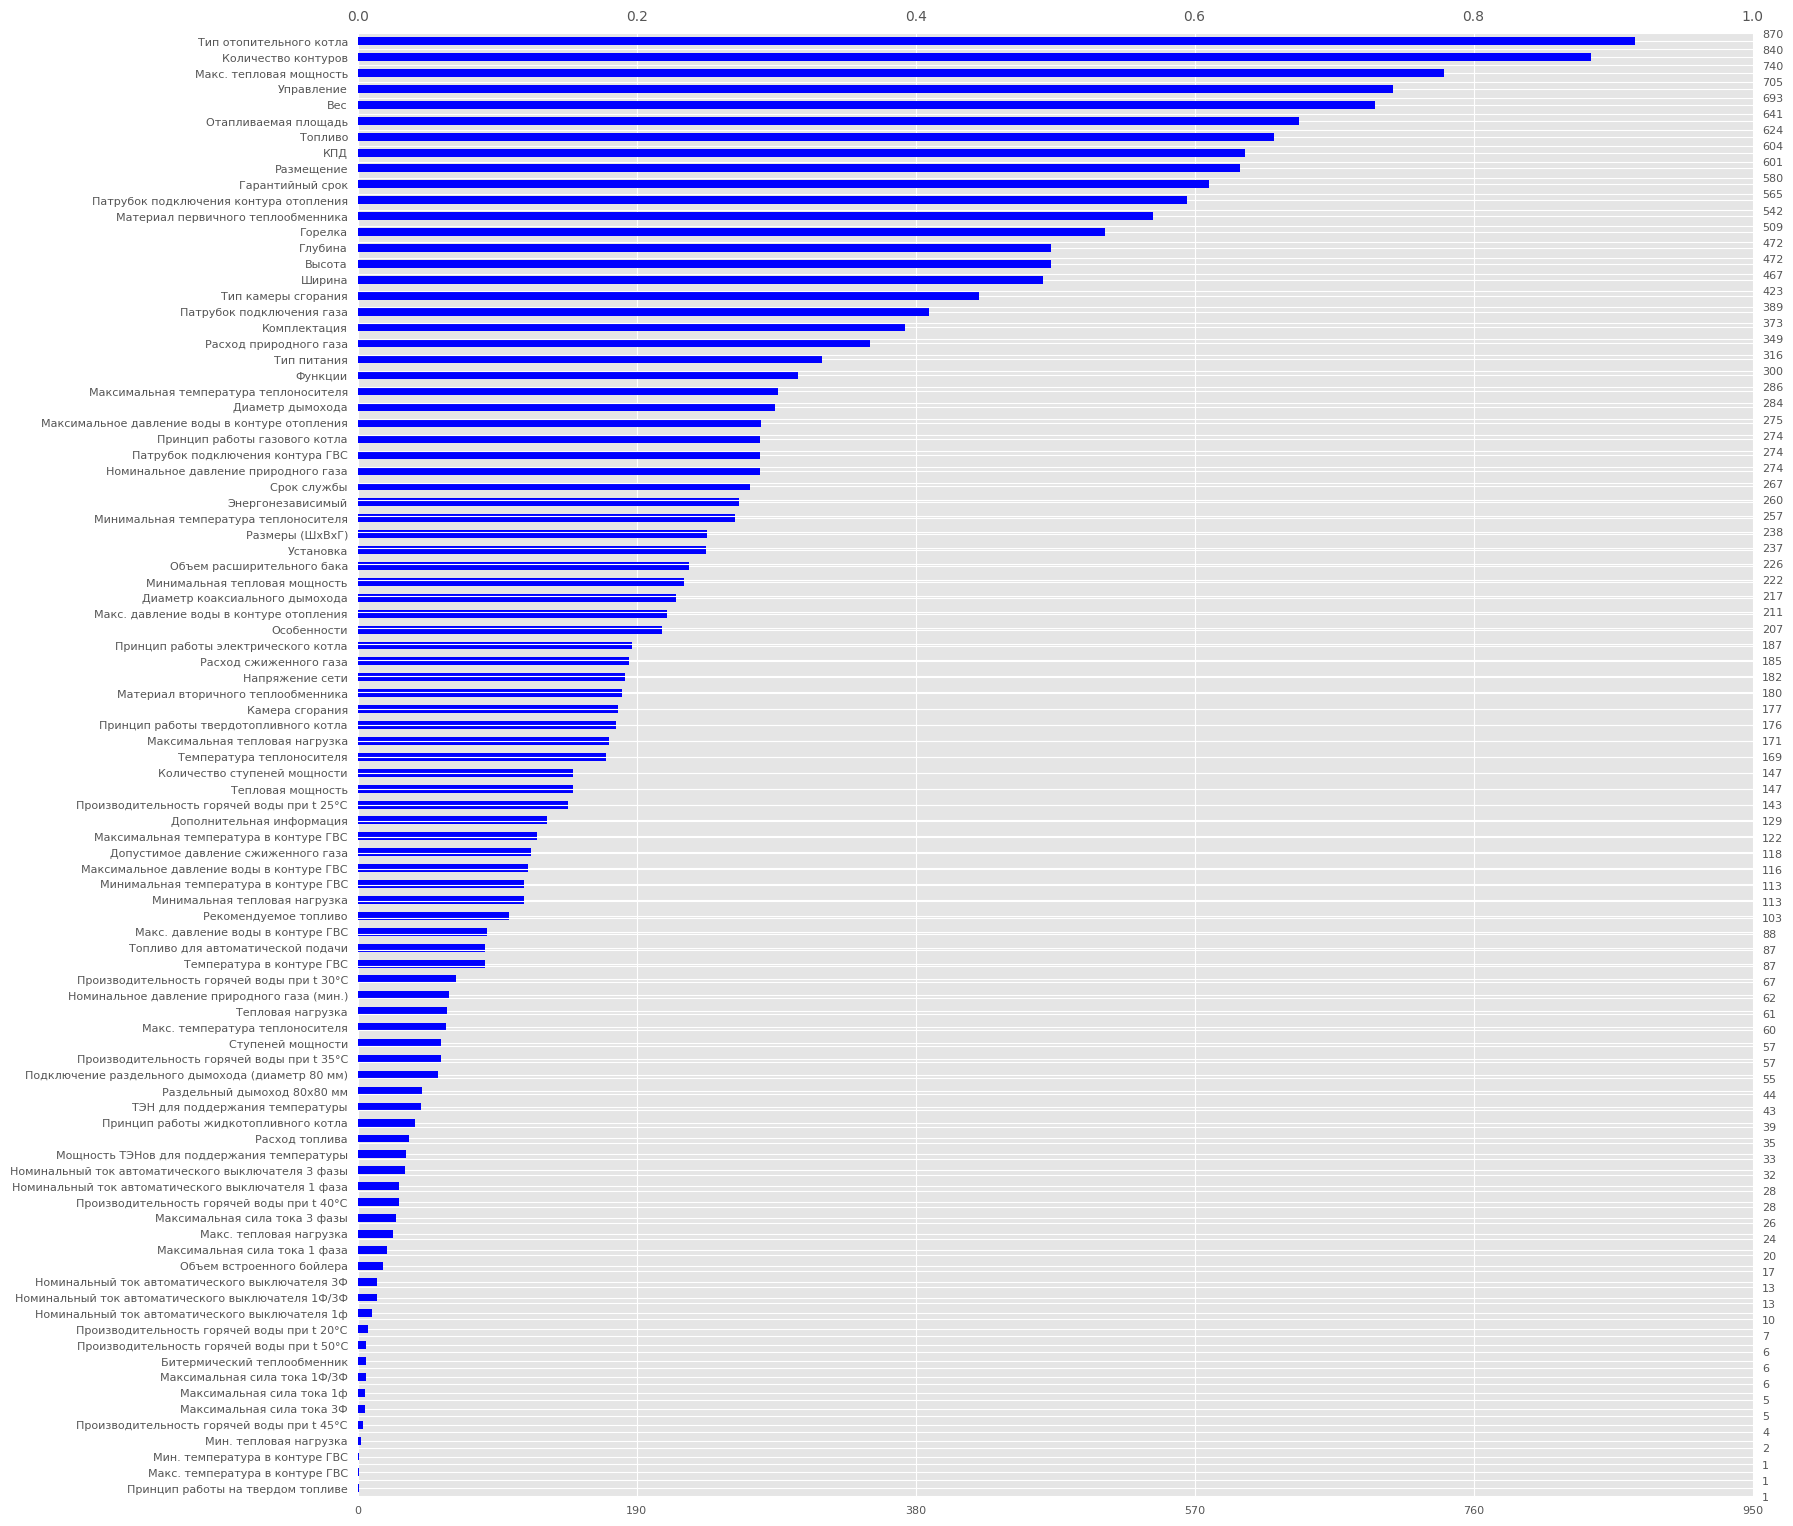

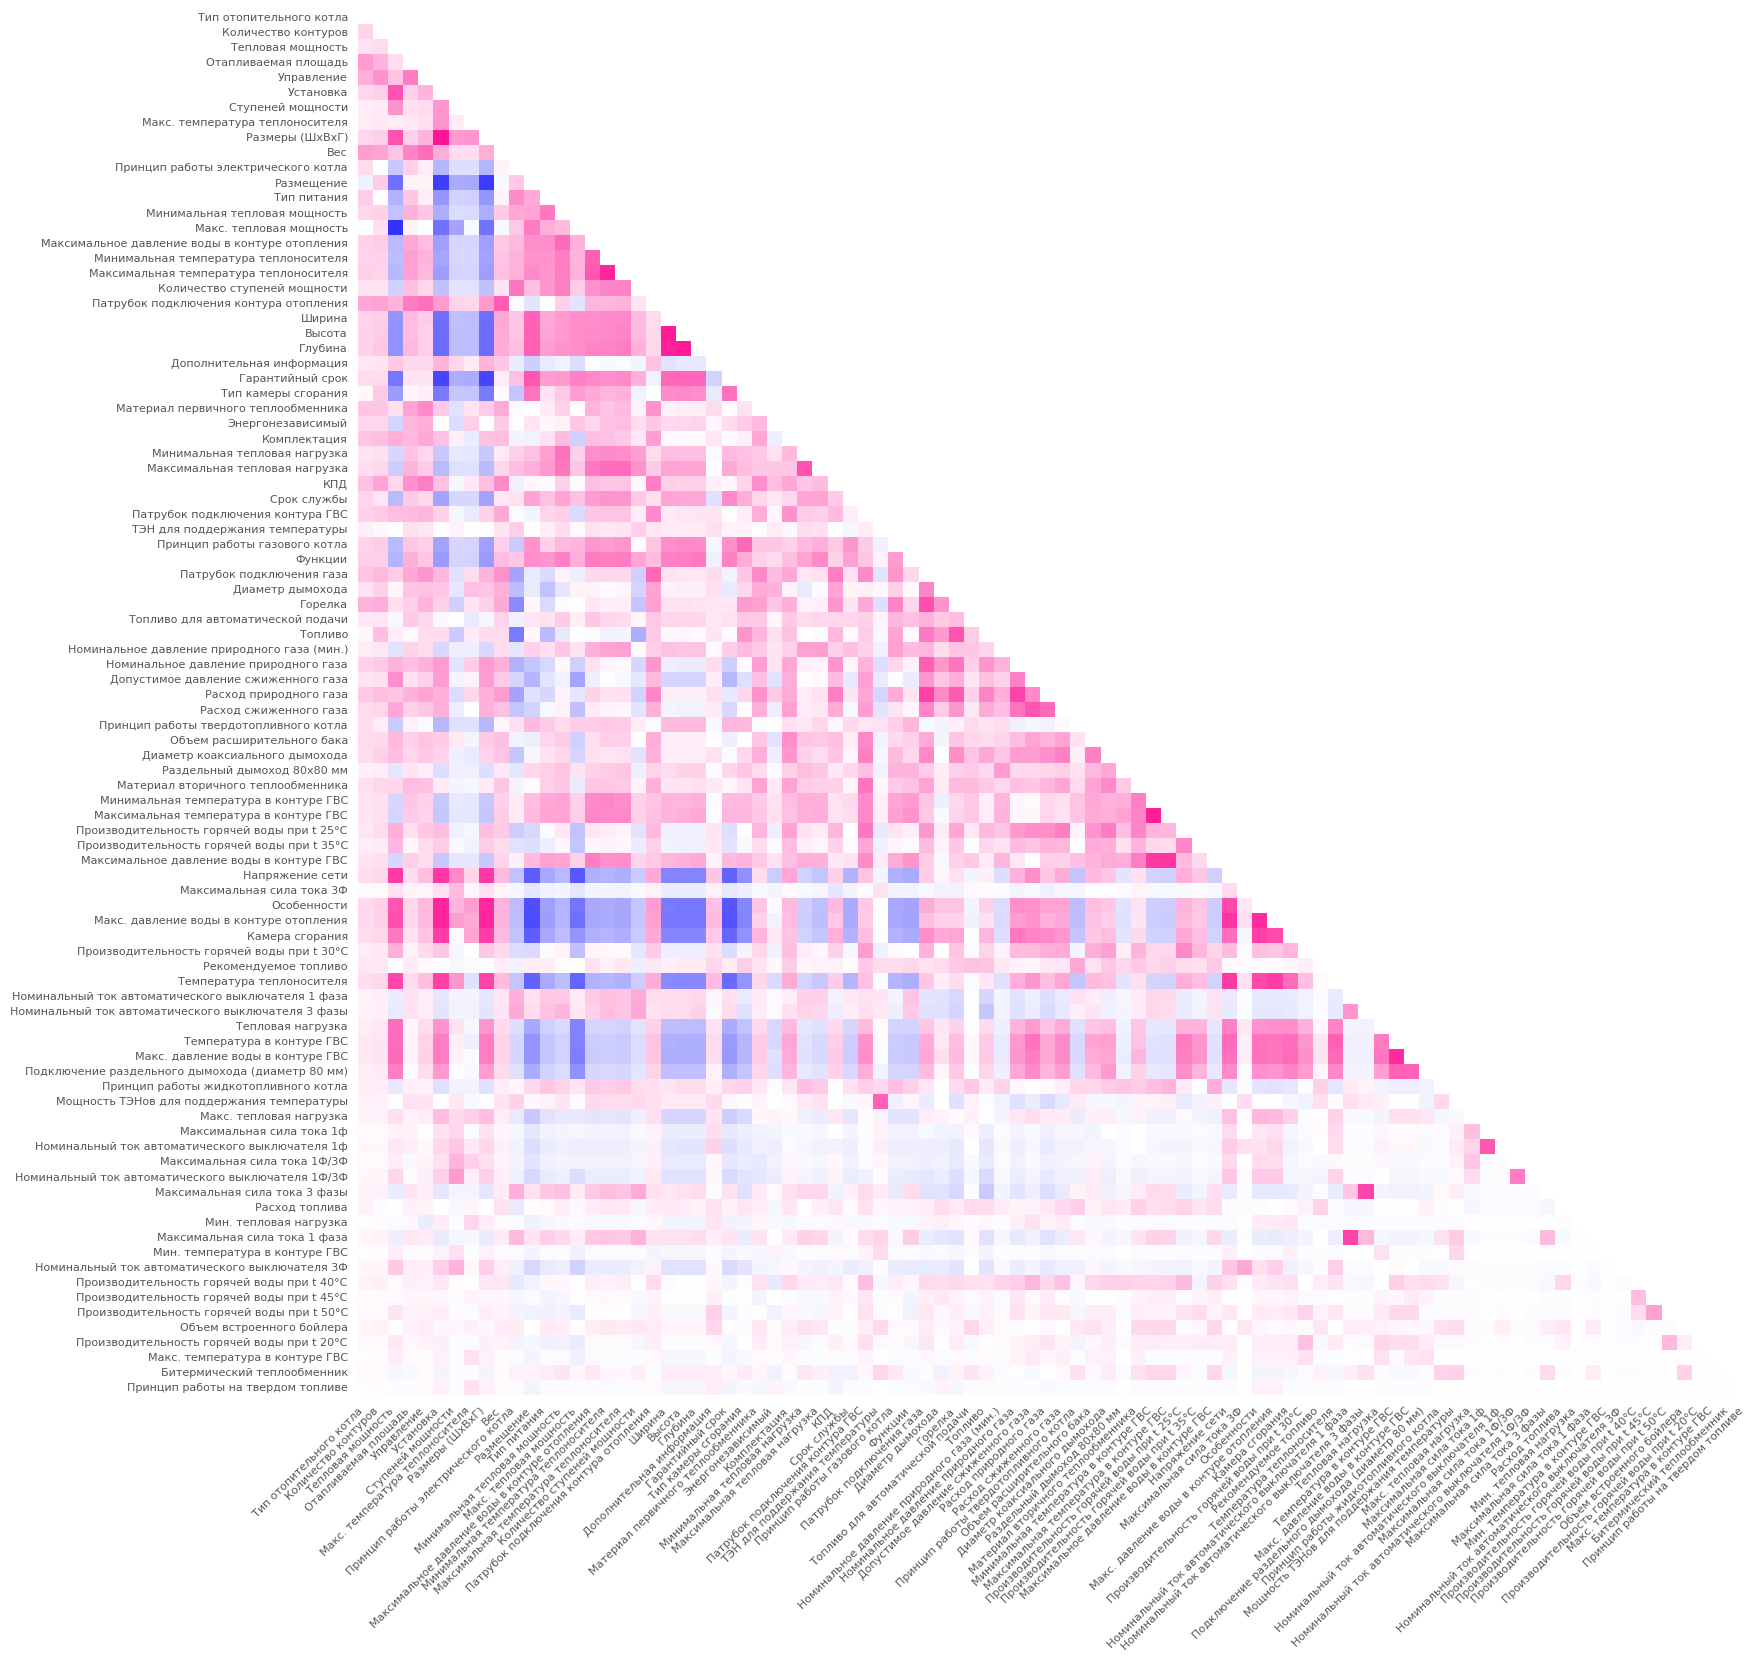

In [27]:
# Смотрим на измененные столбцы с атрибутами, их значения и зависимости
df_to_analyze = df_ym_attr # df_ym_attr # df_wb_attr
f.describe_isna(df_to_analyze, show = True , format = 'big')

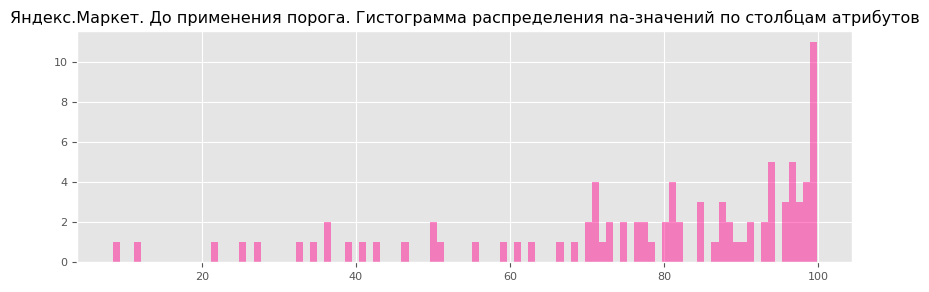

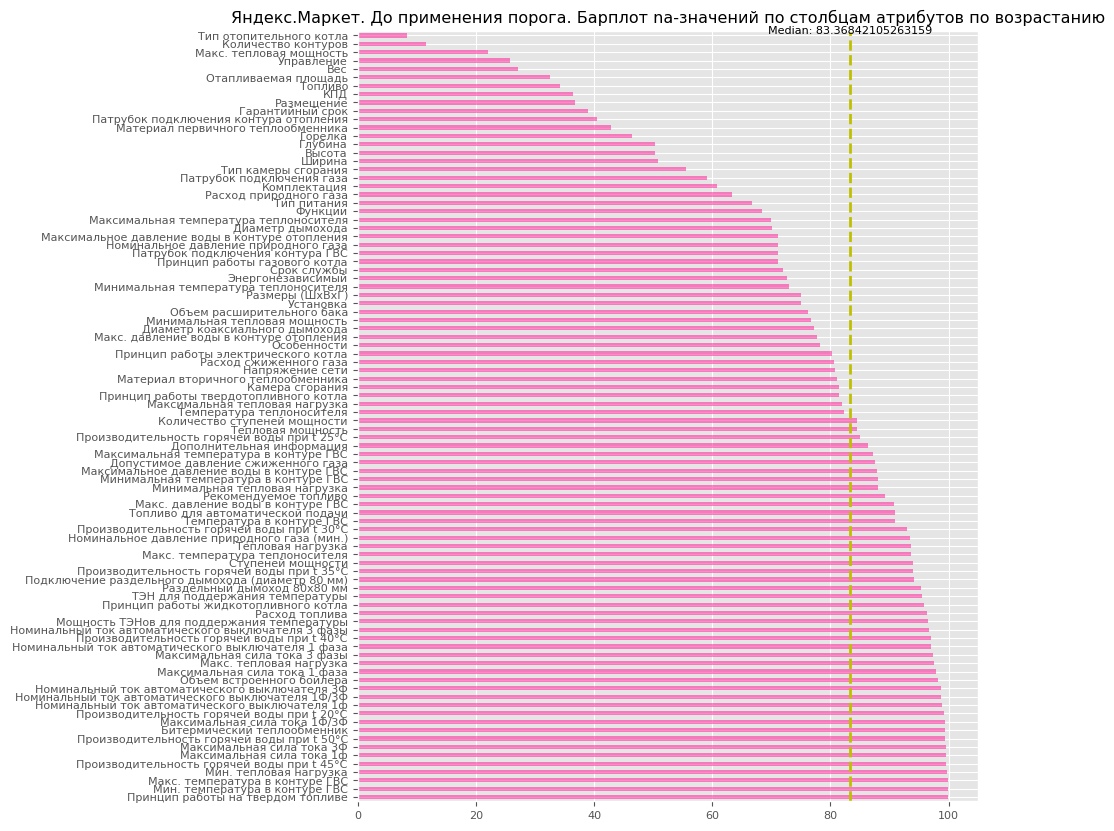

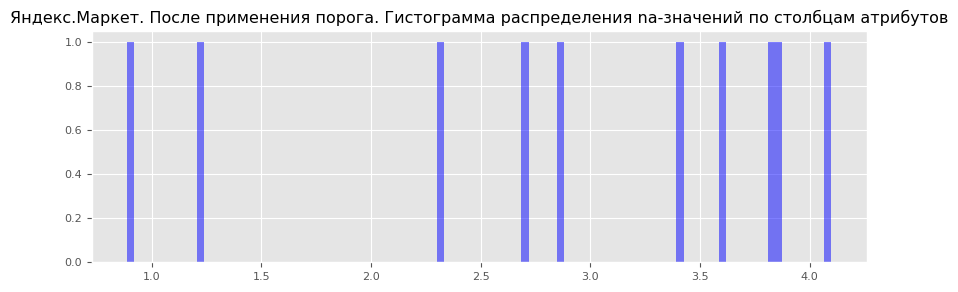

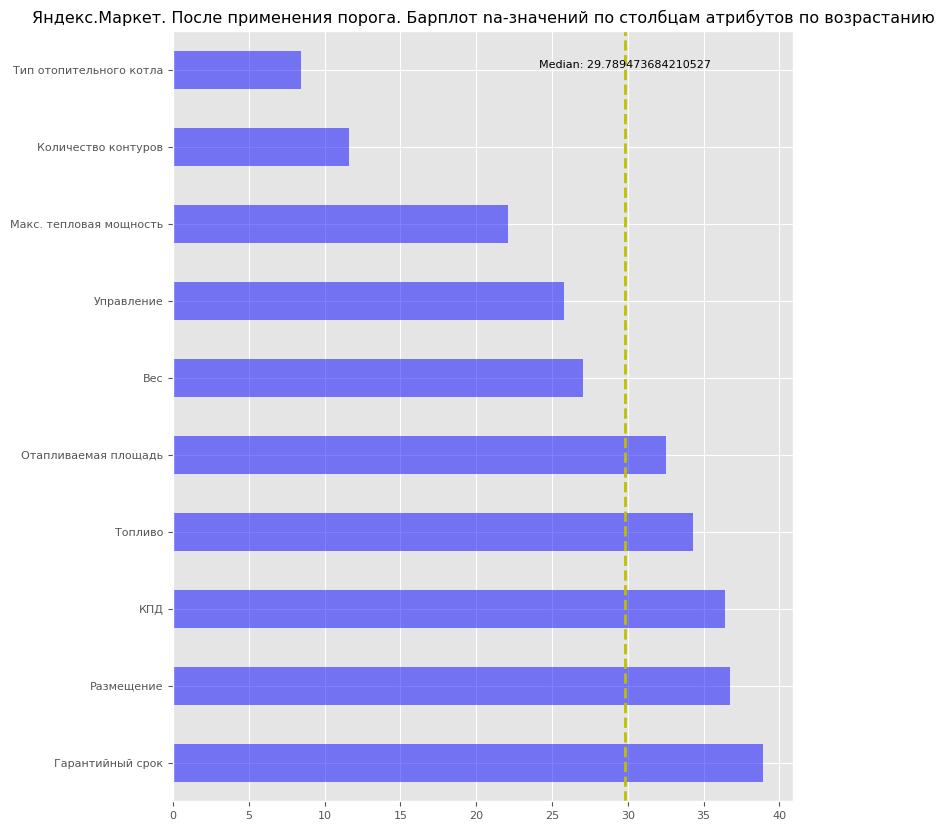

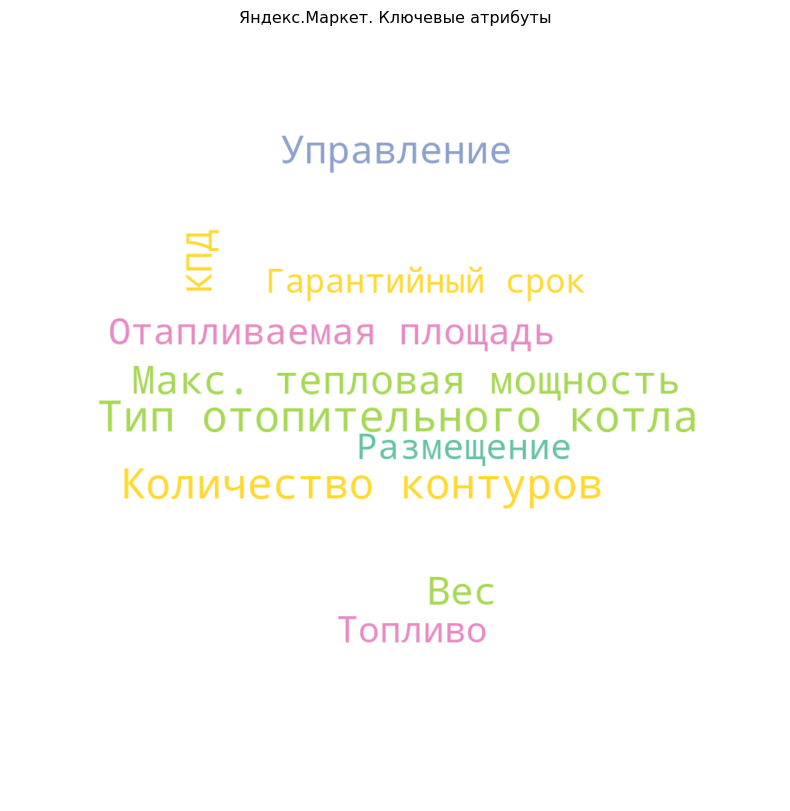

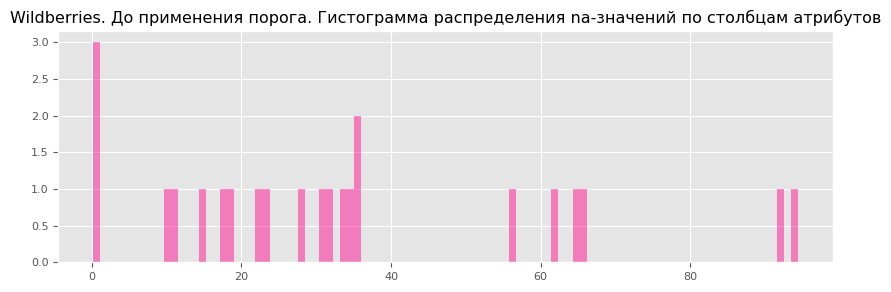

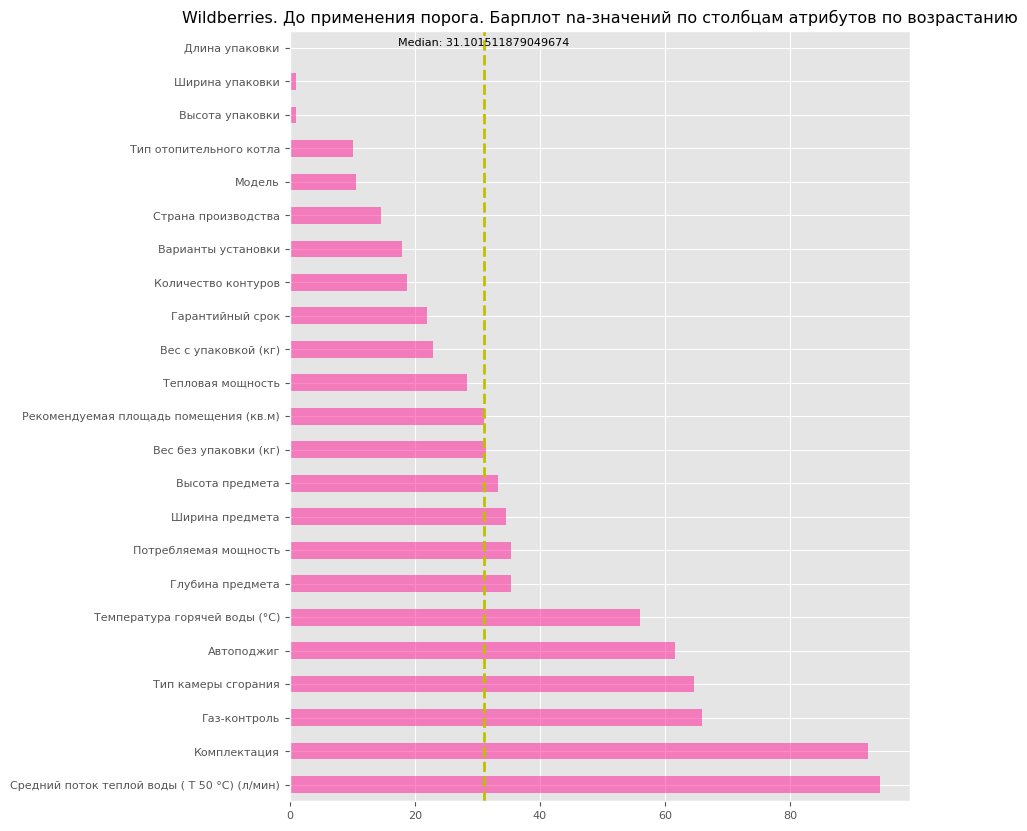

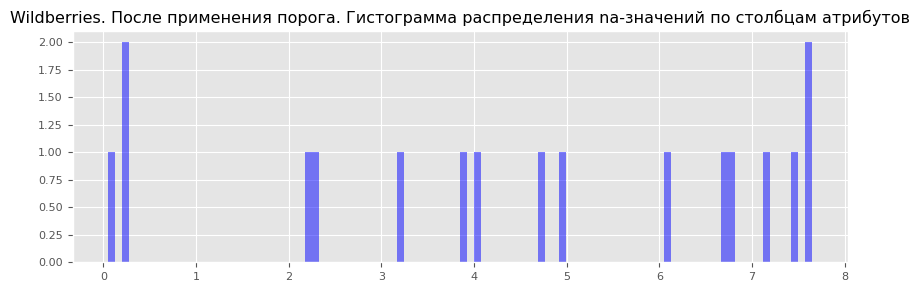

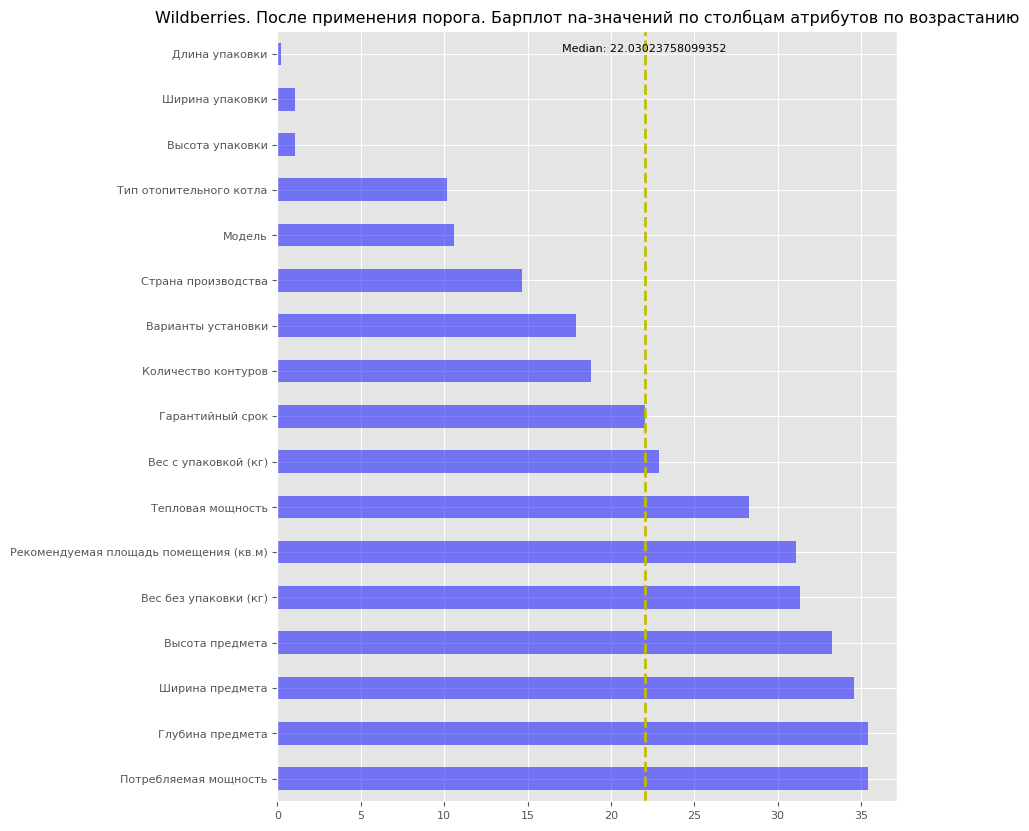

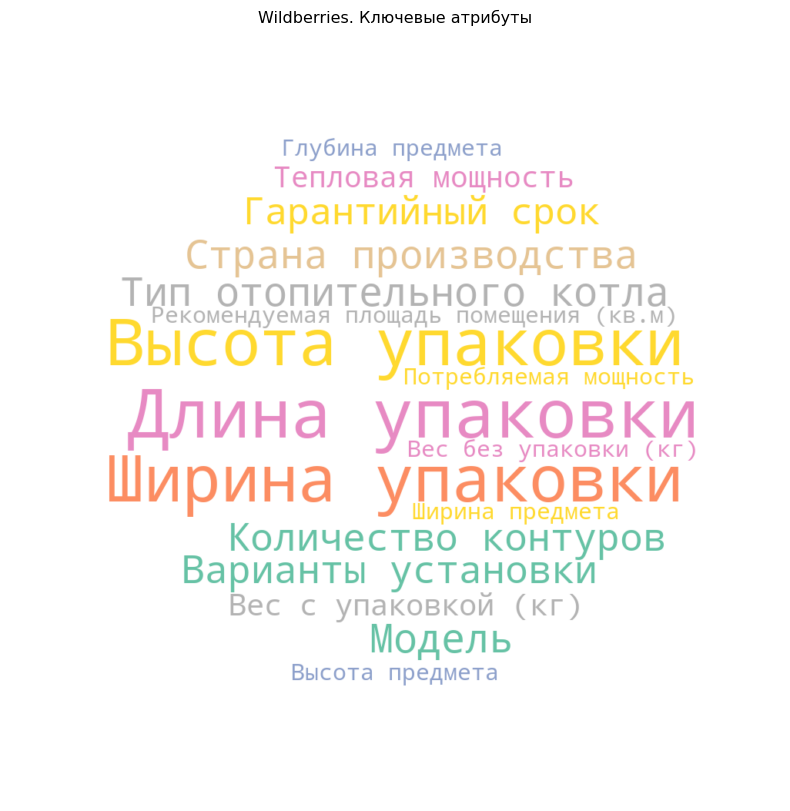

In [28]:
# Выводим итоговые графики ключевых атрибутов для каждой таблицы (wordcloud)
# Выделяем ключевые атрибуты на основе заполненности их значений. Удаляем непопулярные атрибуты, где содержание na превышает порог, и сравниваем графики распределения
df_ym_attr = f.del_na_attr(df_ym_attr, 0.40, 'Яндекс.Маркет')
df_wb_attr = f.del_na_attr(df_wb_attr, 0.40, 'Wildberries')

In [29]:
# Смотрим на топ значений в столбцах атрибутов или слов, с весами и без
dict_df = {'Яндекс.Маркет' : df_ym_attr, 'Wildberries' : df_wb_attr}
for k, df_ in dict_df.items():
    top = 10
    print(f'{k}. Топ {top} значений атрибутов')
    display(f.get_col_top_values(df_, top = top, score = False, norm = True, tokens = False))
    display(f.get_col_top_values(df_, top = top, score = True, norm = True, tokens = True))
    display(f.get_col_top_values(df_, top = top, score = False, norm = True, tokens = True))

Яндекс.Маркет. Топ 10 значений атрибутов


Тип отопительного котла                         Количество контуров  \
0                        газовый                               одноконтурный   
1                  электрический                               двухконтурный   
2         газовый, конвекционный                                           1   
3             электрический, ТЭН                                           2   
4                твердотопливный  двухконтурный, битермический теплообменник   
5       газовый, конденсационный  одноконтурный, битермический теплообменник   
6             Котел отопительный                двухконтурный, одноконтурный   
7  твердотопливный, классический                               1 (отопление)   
8                 жидкотопливный                                         NaN   
9          Твердотопливный котел                                         NaN   

  Отапливаемая площадь                    Управление    Вес  \
0               240 м²                  механическое  31 кг   
1               120 м²                   электронное  29 кг   
2               100 м²         без панели управления  30 кг   
3             240 кв.м                 Дистанционное  13 кг   
4                90 м²                     сенсорное  26 кг   
5               160 м²  Жидкокристаллический дисплей  34 кг   
6                30 м²                     Сенсорное  27 кг   
7               350 м²                           NaN  35 кг   
8                60 м²                           NaN  28 кг   
9               250 м²                           NaN  40 кг   

                        Размещение Макс. тепловая мощность  \
0                        настенный                  24 кВт   
1                        напольный                  12 кВт   
2                       парапетный                  10 кВт   
3              напольный/настенный                  16 кВт   
4  напольный, парапетный/напольный                   9 кВт   
5          настенный, Вертикальная                  35 кВт   
6                              NaN                   6 кВт   
7                              NaN                   3 кВт   
8                              NaN                  15 кВт   
9                              NaN                  20 кВт   

                                                                                    Гарантийный срок  \
0                                                                                               2 г.   
1                                                                                               1 г.   
2                                                                                               3 г.   
3                                                                                            18 мес.   
4                                                                                              5 лет   
5                                                                                            12 мес.   
6                                                                                             6 мес.   
7  60 мес., При соблюдении потребителем условий транспортирования, хранения, монтажа и эксплуатации.   
8                                                      2 г., Гарантия на электрические части 2 года.   
9                                                                                        1 г., 1 год   

      КПД                                                  Топливо  
0    90 %                                            природный газ  
1    92 %                             природный газ, сжиженный газ  
2    99 %                        природный газ, сжиженный газ, Газ  
3    93 %                                       природный газ, Газ  
4    91 %                                                      Газ  
5    95 %  природный газ, сжиженный газ, газ природный и сжиженный  
6    97 %                                                      нет  
7    98 %        древесные брикеты, дрова, уголь, угол

Тип отопительного котла    Количество контуров Отапливаемая площадь  \
0          (газовый, 0.43)  (одноконтурный, 0.56)           (м², 0.28)   
1    (электрический, 0.26)   (двухконтурный, 0.3)           (кв, 0.13)   
2     (конвекционный, 0.1)              (1, 0.01)          (240, 0.05)   
3              (тэн, 0.05)              (2, 0.01)          (120, 0.03)   
4  (твердотопливный, 0.03)  (битермический, 0.01)          (100, 0.02)   
5  (конденсационный, 0.02)  (теплообменник, 0.01)           (30, 0.02)   
6            (котёл, 0.01)       (отопление, 0.0)          (160, 0.02)   
7     (отопительный, 0.01)                    NaN           (90, 0.02)   
8     (классический, 0.01)                    NaN          (350, 0.02)   
9   (жидкотопливный, 0.01)                    NaN           (60, 0.01)   

                    Управление         Вес           Размещение  \
0         (механический, 0.37)   (кг, 0.4)    (настенный, 0.42)   
1          (электронный, 0.34)  (29, 0.02)    (напольный, 0.19)   
2               (панель, 0.01)   (5, 0.02)   (парапетный, 0.02)   
3           (управление, 0.01)  (31, 0.02)  (вертикальный, 0.0)   
4        (дистанционный, 0.01)   (7, 0.02)                  NaN   
5             (сенсорный, 0.0)   (9, 0.02)                  NaN   
6  (жидкокристаллический, 0.0)  (30, 0.02)                  NaN   
7               (дисплей, 0.0)  (26, 0.01)                  NaN   
8                          NaN  (34, 0.01)                  NaN   
9                          NaN   (6, 0.01)                  NaN   

  Макс. тепловая мощность      Гарантийный срок         КПД            Топливо  
0              (квт, 0.4)             (2, 0.11)  (90, 0.12)        (газ, 0.41)  
1              (24, 0.04)             (1, 0.09)  (92, 0.11)  (природный, 0.24)  
2              (12, 0.04)             (3, 0.06)  (99, 0.08)    (сжидить, 0.12)  
3               (5, 0.03)           (мес, 0.04)  (93, 0.08)     (брикет, 0.02)  
4              (10, 0.02)  (эксплуатация, 0.03)  (91, 0.04)      (дрова, 0.02)  
5               (9, 0.02)         (месяц, 0.02)   (9, 0.03)      (уголь, 0.01)  
6               (6, 0.02)   (гарантийный, 0.02)  (97, 0.02)  (древесный, 0.01)  
7              (16, 0.02)      (гарантия, 0.02)  (95, 0.02)   (угольный, 0.01)  
8               (3, 0.02)            (24, 0.02)  (98, 0.02)     (топливо, 0.0)  
9               (4, 0.02)  (обслуживание, 0.01)   (5, 0.02)   (дизельный, 0.0)

Тип отопительного котла Количество контуров Отапливаемая площадь  \
0                 газовый       одноконтурный                   м²   
1           электрический       двухконтурный                   кв   
2           конвекционный                   1                  240   
3                     тэн                   2                  120   
4         твердотопливный       битермический                  100   
5         конденсационный       теплообменник                   30   
6                   котёл           отопление                  160   
7            отопительный                 NaN                   90   
8            классический                 NaN                  350   
9          жидкотопливный                 NaN                   60   

             Управление Вес    Размещение Макс. тепловая мощность  \
0          механический  кг     настенный                     квт   
1           электронный  29     напольный                      24   
2                панель   5    парапетный                      12   
3            управление  31  вертикальный                       5   
4         дистанционный   7           NaN                      10   
5             сенсорный   9           NaN                       9   
6  жидкокристаллический  30           NaN                       6   
7               дисплей  26           NaN                      16   
8                   NaN  34           NaN                       3   
9                   NaN   6           NaN                       4   

  Гарантийный срок КПД    Топливо  
0                2  90        газ  
1                1  92  природный  
2                3  99    сжидить  
3              мес  93     брикет  
4     эксплуатация  91      дрова  
5            месяц   9      уголь  
6      гарантийный  97  древесный  
7         гарантия  95   угольный  
8               24  98    топливо  
9     обслуживание   5  дизельный

Wildberries. Топ 10 значений атрибутов


Тип отопительного котла  \
0                                                                                                электрический   
1                                                                                                      газовый   
2                                                                                                Электрический   
3                                               Электрокотел для отопления; электрический котел; электрический   
4                                                                                          электрический котел   
5                                         Электрокотел для отопления; электрокотел отопительный; электрический   
6                                                                           электрический; электрический котел   
7                                                Электрокотел для отопления; электрический; отопительный котел   
8                                                электрический; электрокотел для отопления; отопительный котел   
9  Электрический котел отопления; Электрокотёл для отопления; Котёл Ресурс электрический для системы отопления   

  Рекомендуемая площадь помещения (кв.м) Тепловая мощность  \
0                               90 кв. м             9 кВт   
1                               60 кв. м            12 кВт   
2                               30 кв. м             6 кВт   
3                              120 кв. м             3 кВт   
4                              150 кв. м            15 кВт   
5                              240 кв. м                 6   
6                               75 кв. м                 9   
7                               45 кв. м            18 кВт   
8                              180 кв. м             5 квт   
9                               40 кв. м               4.5   

                                    Варианты установки Страна производства  \
0                                            настенный              Россия   
1  настенный; Настенное крепление; настенно-потолочный               Китай   
2                                 напольный; настенный              Италия   
3                                            Настенный    Республика Корея   
4                                  Настенное крепление              Турция   
5                                 настенный; напольный            Словакия   
6                                          "настенный"               Чехия   
7                       настенный; Настенное крепление                 NaN   
8                                  настенный; на стену                 NaN   
9             настенный; на стену; Настенное крепление                 NaN   

                                         Количество контуров  \
0                                                          1   
1                                           одноконтурный; 1   
2                                              одноконтурный   
3                                                          2   
4                                           1; одноконтурный   
5                          2; двухконтурный; котел - колонка   
6                                              двухконтурный   
7  2; двухконтурный; контур отопления и контур водоснабжения   
8                                                   1 контур   
9                                                     2; два   

  Потребляемая мощность Глубина предмета Ширина предмета Высота предмета  \
0               6000 Вт            20 см           32 см           51 см   
1               9000 Вт            13 см           40 см           50 см   
2               3000 Вт            30 см           18 см           58 см   
3              12000 Вт          12.5 см           27 см           60 см   
4               4500 Вт            17 см           25 см           70 см   
5                220 Вт            19 см           39 см           73 см   
6              15000 Вт            14 см         20.5

Тип отопительного котла Рекомендуемая площадь помещения (кв.м)  \
0   (электрический, 0.47)                             (кв, 0.41)   
1           (котёл, 0.12)                             (90, 0.05)   
2    (электрокотёл, 0.11)                             (60, 0.05)   
3        (отопление, 0.1)                             (30, 0.04)   
4         (газовый, 0.05)                            (120, 0.04)   
5    (отопительный, 0.05)                            (150, 0.03)   
6         (электро, 0.01)                            (240, 0.02)   
7         (система, 0.01)                             (75, 0.02)   
8          (ресурс, 0.01)                             (45, 0.02)   
9    (конвекционный, 0.0)                            (180, 0.02)   

  Тепловая мощность     Варианты установки Страна производства  \
0       (квт, 0.32)      (настенный, 0.59)      (россия, 0.71)   
1         (5, 0.09)      (крепление, 0.11)       (китай, 0.06)   
2         (9, 0.07)     (потолочный, 0.09)      (италия, 0.03)   
3         (6, 0.06)      (напольный, 0.06)  (республика, 0.01)   
4         (3, 0.05)          (стена, 0.01)       (корея, 0.01)   
5         (4, 0.05)          (котёл, 0.01)      (турция, 0.01)   
6        (12, 0.05)      (отопление, 0.01)     (словакия, 0.0)   
7        (15, 0.03)      (накладный, 0.01)        (чехия, 0.0)   
8         (7, 0.03)   (электрокотёл, 0.01)                 NaN   
9        (18, 0.02)  (электрический, 0.01)                 NaN   

     Количество контуров Потребляемая мощность  Глубина предмета  \
0              (1, 0.53)            (вт, 0.38)  (смотреть, 0.35)   
1  (одноконтурный, 0.24)          (6000, 0.03)        (20, 0.08)   
2              (2, 0.06)          (9000, 0.03)         (5, 0.06)   
3  (двухконтурный, 0.01)          (3000, 0.03)        (13, 0.05)   
4         (контур, 0.01)             (5, 0.03)        (30, 0.04)   
5           (котёл, 0.0)         (12000, 0.03)        (12, 0.03)   
6         (колонка, 0.0)          (4500, 0.02)        (19, 0.02)   
7       (отопление, 0.0)           (220, 0.01)        (17, 0.02)   
8   (водоснабжение, 0.0)         (15000, 0.01)        (16, 0.02)   
9                    NaN            (12, 0.01)        (14, 0.01)   

    Ширина предмета   Высота предмета Вес с упаковкой (кг)  \
0  (смотреть, 0.38)  (смотреть, 0.38)           (кг, 0.37)   
1        (32, 0.09)        (51, 0.08)           (16, 0.07)   
2        (40, 0.06)        (50, 0.04)            (5, 0.06)   
3        (18, 0.05)         (5, 0.03)            (8, 0.06)   
4         (5, 0.03)        (60, 0.03)            (9, 0.04)   
5        (20, 0.02)        (58, 0.03)            (6, 0.04)   
6        (27, 0.02)        (70, 0.03)            (7, 0.04)   
7        (25, 0.01)        (73, 0.02)           (27, 0.03)   
8        (39, 0.01)        (65, 0.02)           (10, 0.02)   
9        (22, 0.01)        (54, 0.02)           (24, 0.02)   

  Вес без упаковки (кг)   Длина упаковки  Высота упаковки  Ширина упаковки  \
0            (кг, 0.36)  (смотреть, 0.5)  (смотреть, 0.5)  (смотреть, 0.5)   
1            (13, 0.07)       (25, 0.05)       (65, 0.07)       (35, 0.06)   
2             (6, 0.06)       (23, 0.04)       (70, 0.05)       (25, 0.03)   
3             (5, 0.06)       (20, 0.03)       (20, 0.04)       (40, 0.03)   
4             (8, 0.04)       (18, 0.02)       (55, 0.02)       (15, 0.02)   
5             (7, 0.04)       (17, 0.02)       (18, 0.02)       (13, 0.02)   
6            (25, 0.03)       (46, 0.02)       (23, 0.02)       (22, 0.02)   
7             (9, 0.03)       (52, 0.02)       (15, 0.02)       (34, 0.02)   
8            (10, 0.02)       (27, 0.02)       (80, 0.02)       (23, 0.02)   
9            (24, 0.02)       (50, 0.02)       (66, 0.01)       (27, 0.02)   

           Модель Гарантийный срок  
0    (эвпм, 0.07)        (1, 0.29)  
1     (квт, 0.06)    (месяц, 0.13)  
2       (6, 0.04)        (2, 0.12)  
3  (intois, 0.04)        (18, 0.1)  
4       (9, 0.03)        (3, 0.05)  
5       (5, 0

Тип отопительного котла Рекомендуемая площадь помещения (кв.м)  \
0           электрический                                     кв   
1                   котёл                                     90   
2            электрокотёл                                     60   
3               отопление                                     30   
4                 газовый                                    120   
5            отопительный                                    150   
6                 электро                                    240   
7                 система                                     75   
8                  ресурс                                     45   
9           конвекционный                                    180   

  Тепловая мощность Варианты установки Страна производства  \
0               квт          настенный              россия   
1                 5          крепление               китай   
2                 9         потолочный              италия   
3                 6          напольный          республика   
4                 3              стена               корея   
5                 4              котёл              турция   
6                12          отопление            словакия   
7                15          накладный               чехия   
8                 7       электрокотёл                 NaN   
9                18      электрический                 NaN   

  Количество контуров Потребляемая мощность Глубина предмета Ширина предмета  \
0                   1                    вт         смотреть        смотреть   
1       одноконтурный                  6000               20              32   
2                   2                  9000                5              40   
3       двухконтурный                  3000               13              18   
4              контур                     5               30               5   
5               котёл                 12000               12              20   
6             колонка                  4500               19              27   
7           отопление                   220               17              25   
8       водоснабжение                 15000               16              39   
9                 NaN                    12               14              22   

  Высота предмета Вес с упаковкой (кг) Вес без упаковки (кг) Длина упаковки  \
0        смотреть                   кг                    кг       смотреть   
1              51                   16                    13             25   
2              50                    5                     6             23   
3               5                    8                     5             20   
4              60                    9                     8             18   
5              58                    6                     7             17   
6              70                    7                    25             46   
7              73                   27                     9             52   
8              65                   10                    10             27   
9              54                   24                    24             50   

  Высота упаковки Ширина упаковки  Модель Гарантийный срок  
0        смотреть        смотреть    эвпм                1  
1              65              35     квт            месяц  
2              70              25       6                2  
3              20              40  intois               18  
4              55              15       9                3  
5              18              13       5               12  
6              23              22       4                5  
7              15              34      12             дата  
8              80              23       3              мес  
9              66              27   котёл          покупка


##### Выводы

In [30]:
# Наименования и количество атрибутов после предобработки
dict_df = {'Яндекс.Маркет' : df_ym_attr, 'Wildberries' : df_wb_attr}
for k, df_ in dict_df.items():
    print(f'Количество атрибутов {k}:', len(list(df_.columns)))
    print(f'Атрибуты {k}:', list(df_.columns))

Количество атрибутов Яндекс.Маркет: 10
Атрибуты Яндекс.Маркет: ['Тип отопительного котла', 'Количество контуров', 'Отапливаемая площадь', 'Управление', 'Вес', 'Размещение', 'Макс. тепловая мощность', 'Гарантийный срок', 'КПД', 'Топливо']
Количество атрибутов Wildberries: 17
Атрибуты Wildberries: ['Тип отопительного котла', 'Рекомендуемая площадь помещения (кв.м)', 'Тепловая мощность', 'Варианты установки', 'Страна производства', 'Количество контуров', 'Потребляемая мощность', 'Глубина предмета', 'Ширина предмета', 'Высота предмета', 'Вес с упаковкой (кг)', 'Вес без упаковки (кг)', 'Длина упаковки', 'Высота упаковки', 'Ширина упаковки', 'Модель', 'Гарантийный срок']


In [31]:
print('Исходное количество позиций')
print('Яндекс.Маркет',df_ym_input.shape[0])
print('Wildberries', df_wb_input.shape[0])
print('Количество позиций после предобработки')
print('Яндекс.Маркет', df_ym.shape[0])
print('Wildberries', df_wb.shape[0])

Исходное количество позиций
Яндекс.Маркет 1187
Wildberries 1310
Количество позиций после предобработки
Яндекс.Маркет 950
Wildberries 463


In [32]:
len_wb_input = len(df_wb_input)
len_ym_input = len(df_ym_input)
len_wb = len(df_wb)
len_ym = len(df_ym)

print('Соответствие запросу')
print(f'Wildberries: {len_wb}/{len_wb_input}, доля {round(len_wb / len_wb_input, 2)}')
print(f'Яндекс.Маркет: {len_ym}/{len_ym_input}, доля {round(len_ym / len_ym_input, 2)}')

Соответствие запросу
Wildberries: 463/1310, доля 0.35
Яндекс.Маркет: 950/1187, доля 0.8


Проведена предобработка данных о товарах (тема "Отопительные котлы") с маркетплейсов Wildberries и Яндекс.Маркет  
Выполнена фильтрация по наименованиям товаров и их нумеричесим метрикам. Данные на входе требовалось очистить, так как среди товаров встречались позиции, не относящиеся к тематике. Кроме того, в Яндекс.Маркет есть товары с отсутствующими ценами, которые также были удалены вследствие предположения о неактуальности.  
В ходе исследования по нумерическим столбцам, часть из них (оценки товаров и их количество) была удалена из-за недостатка данных. Также сделана проверка на ценовые выбросы, которая показала отсутсиве таковых, не смотря на смещение рапределения, при этом выявлены ценовые аномалии (в Яндекс.Маркет асимметрия более чем в 5 раз превышает нормальные значения, и все данные имеют значимость). Данные приведены с нормальному распределению и масштабированы в диапазон от 0 до 1.

В целом представленность товаров на Wildberries и Яндекс.Маркет имеет различия.  
Во-первых, соответсвие запросу в Wildberries гораздо ниже (35%), чем в Яндекс.Маркет (80%).  
Во-вторых ценовой диапазон значительно отличается, средняя цен в Wildberries более чем в два раза ниже, а медиана цены почти в три (доля товаров стоимостью ниже 10000 рулей составляет 35%)  
В-третьих атрибутивный состав и ключевые атрибуты различны. В Яндекс.Маркет атрибутивный состав изначально шире (92 атрибута против 23 в Wildberries), но при этом заполненность данных ниже (Яндекс.Маркет: медиана пустых значений 83, Wildberries: медиана 31). По сходству наименований некоторых атрибутов (например, 'Максимальная сила тока 3Ф' и 'Максимальная сила тока 3 фазы' в Яндекс.Маркет) есть основания полагать, что часть из них дублирует друг друга. После выделения ключевых атрибутов на основе полноты данных осталось 10 атрибутов в Яндекс.Маркет и 17 в Wildberries. При этом медианы процентов пустых значений стали приближаться (Яндекс.Маркет: 30%, Wildberries: 22%). В топ ключевых атрибутов Wildberries входят параметры упаковки (Длина, Ширина и Высота), в то время как в Яндекс.Маркет на первый план выходят функциональные характеристики (Тип отопительного котла, Количество контуров, Максимальная тепловая мощность).

### 2. Сравнение атрибутов Wildberries и ЯндексМаркет для переноса данных

##### Перенос данных на основании сходства наименований атрибутов

* <b>Поиск дополняющих друг друга атрибутов</b>. Для проверки попарно сравниваем столбцы с атрирбутами на предмет совместно встречаемых данных (данные не должны одновременно встречаться в строках)
* <b>Сравнение наименований атрибутов</b>. Сравниваем атрибуты в двух таблицах по сходству наименований
* <b>Перенос данных</b>. Переносим данные, если найдено сходство

In [33]:
# Для проверки попарно сравниваем столбцы на предмет совместно встречаемых данных (данные не должны одновременно встречаться в строках)

f.find_sim_cols(df_wb_attr) # df_ym_attr df_wb_attr

[]

При нахождении пар далее можно провести анализ соответствия значений выбранных столбцов и при необходимости объединить столбцы в один. Также можно сравнивать не только пары , но и несколько столбцов методом рекурсии

In [34]:
# Сравниваем атрибуты в двух таблицах по наименованиям столбцов 
for model in ['spacy', 'fuzz']:
    print(model)
    display(f.get_similarities(df_wb_attr.columns, df_ym_attr.columns, model = model, threshold = 50))

spacy


c:\Users\Art\VSCodeProjects\test\parser_data\functions.py:640: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim = doc1.similarity(doc2)  * 100


docs_1     sim                   docs_2
8                        Гарантийный срок  100.00         Гарантийный срок
5                     Количество контуров  100.00      Количество контуров
0                 Тип отопительного котла  100.00  Тип отопительного котла
7                   Потребляемая мощность   71.14  Макс. тепловая мощность
4                       Тепловая мощность   71.14  Макс. тепловая мощность
2  Рекомендуемая площадь помещения (кв.м)   67.63     Отапливаемая площадь
6                   Потребляемая мощность   63.06  Тип отопительного котла
3                       Тепловая мощность   63.06  Тип отопительного котла
1                 Тип отопительного котла   51.81  Макс. тепловая мощность

fuzz


docs_1    sim                   docs_2
8                        Гарантийный срок  100.0         Гарантийный срок
4                     Количество контуров  100.0      Количество контуров
0                 Тип отопительного котла  100.0  Тип отопительного котла
2                       Тепловая мощность   91.2  Макс. тепловая мощность
6                    Вес с упаковкой (кг)   69.0                      Вес
7                   Вес без упаковки (кг)   68.4                      Вес
5                   Потребляемая мощность   59.8  Макс. тепловая мощность
3                      Варианты установки   57.2         Гарантийный срок
1  Рекомендуемая площадь помещения (кв.м)   55.0     Отапливаемая площадь

Также можем сравнивать атрибуты по наименованиям столбцов с помощью метода similarity_search_with_score библиотеки langchain

In [35]:
openai_key = getpass.getpass("OpenAI API Key:") # получение ключа API от пользователя и установка его как переменной окружения
os.environ["OPENAI_API_KEY"] = openai_key

# Сравниваем атрибуты в двух таблицах по наименованиям столбцов 
df_cols_sim = f.get_faiss_similarities(df_ym_attr.columns, df_wb_attr.columns, 4)

# df_attrs_sim = pd.read_csv('gpt_files/df_attrs_sim.csv')
# df_attrs_sim

text_to_compare  \
0                  Тип отопительного котла   
1                      Количество контуров   
2                         Гарантийный срок   
3                        Тепловая мощность   
4                     Вес с упаковкой (кг)   
5                    Вес без упаковки (кг)   
6                    Потребляемая мощность   
7   Рекомендуемая площадь помещения (кв.м)   
8                       Варианты установки   
9                                   Модель   
10                     Страна производства   
11                         Ширина предмета   
12                         Высота предмета   
13                         Ширина упаковки   
14                          Длина упаковки   
15                         Высота упаковки   
16                        Глубина предмета   

                                     0                                   1  \
0     ('Тип отопительного котла', 0.0)  ('Макс. тепловая мощность', 0.314)   
1         ('Количество контуров', 0.0)     ('Отапливаемая площадь', 0.409)   
2            ('Гарантийный срок', 0.0)               ('Размещение', 0.364)   
3   ('Макс. тепловая мощность', 0.167)                  ('Топливо', 0.316)   
4                       ('Вес', 0.224)         ('Гарантийный срок', 0.409)   
5                       ('Вес', 0.249)         ('Гарантийный срок', 0.422)   
6   ('Макс. тепловая мощность', 0.257)     ('Отапливаемая площадь', 0.339)   
7      ('Отапливаемая площадь', 0.285)               ('Размещение', 0.307)   
8                ('Размещение', 0.299)  ('Тип отопительного котла', 0.345)   
9                 ('Управление', 0.32)                      ('КПД', 0.336)   
10                      ('КПД', 0.341)               ('Размещение', 0.343)   
11                      ('Вес', 0.343)      ('Отапливаемая площадь', 0.37)   
12                      ('Вес', 0.345)               ('Размещение', 0.357)   
13                      ('Вес', 0.353)     ('Отапливаемая площадь', 0.356)   
14                      ('Вес', 0.357)     ('Отапливаемая площадь', 0.367)   
15     ('Отапливаемая площадь', 0.358)                      ('Вес', 0.365)   
16                      ('Вес', 0.371)     ('Отапливаемая площадь', 0.377)   

                                     2                                   3  
0                   ('Топливо', 0.355)     ('Отапливаемая площадь', 0.357)  
1                ('Размещение', 0.423)                      ('Вес', 0.427)  
2                       ('КПД', 0.416)     ('Отапливаемая площадь', 0.416)  
3   ('Тип отопительного котла', 0.318)     ('Отапливаемая площадь', 0.332)  
4                ('Размещение', 0.411)                      ('КПД', 0.412)  
5                ('Размещение', 0.432)  ('Макс. тепловая мощность', 0.437)  
6                       ('КПД', 0.358)  ('Тип отопительного котла', 0.362)  
7                       ('КПД', 0.398)  ('Макс. тепловая мощность', 0.398)  
8          ('Гарантийный срок', 0.364)     ('Отапливаемая площадь', 0.382)  
9                 ('Размещение', 0.34)  ('Тип отопительного котла', 0.365)  
10     ('Отапливаемая площадь', 0.366)               ('Управление', 0.377)  
11         ('Гарантийный срок', 0.382)               ('Размещение', 0.388)  
12     ('Отапливаемая площадь', 0.366)                      ('КПД', 0.382)  
13         ('Гарантийный срок', 0.376)                ('Размещение', 0.38)  
14         ('Гарантийный срок', 0.376)               ('Размещение', 0.396)  
15               ('Размещение', 0.378)                      ('КПД', 0.404)  
16  ('Макс. тепловая мощность', 0.398)                 ('Размещение', 0.4)

Видно, что атрибуты: Тип отопительного котла, Количество контуров	, Гарантийный срок имеют 100% соответствие. При этом есть неявное  соответствие столбцов Рекомендуемая площадь помещения (кв.м) и Отапливаемая площадь  
При приведении описания позиций из Wildberries к модели Яндекс.Маркет можно перенести данные этих столбцов  
Также можно сравнивать как топ слов в значениях атрибутов, так и топ слов вместе с наименованиями атрибутов  
Для заполнения оставшихся столбцов атрибутов можно ориентироваться на информацию в текстах, описывающих товар

### 3. Сравнение атрибутов ЯндексМаркет и частей текстов описания товаров в Wildberries для переноса данных

##### Перенос данных на основании сходства наименований атрибутов и частей текста описания товара

* <b>Подготовка шаблона для заполнения</b>. Создание шаблона из основных столбцов таблицы Wildberries с добавлением пустых столбцов с наименованиями атрибутов ЯндексМаркет 
* <b>Сравнение наименований атрибутов и частей текста</b>. Сравниваем атрибуты ЯндексМаркет с чанками или спанами текстов описания товаров Wildberries
* <b>Перенос данных</b>. Переносим данные, если найдено сходство

In [ ]:
# Создание шаблона для заполнения
df_wb_text = df_wb.iloc[:, :5]

text_splitter = NLTKTextSplitter(chunk_size=32, chunk_overlap=0) # создание сплитера

# Функция токенизации предложений из описания товара
def tokenize_sent(text):
    document = [Document(page_content=text)] # перевод текста в формат документа
    return text_splitter.split_documents(document) # разделение документа на чанки

df_wb_text['tokenized_sent_NLTKTextSplitter'] = df_wb_text['text'].apply(lambda x: tokenize_sent(x))

# Добавление пустых столбцов с атрибутами
for i in df_ym_attr.columns:
    df_wb_text[i] = np.NaN

df_template = df_wb_text.copy()

In [37]:
# Заполняем шаблон атрибутами, найденными в тексте описания товара
for i, sample in enumerate(df_template['tokenized_sent_NLTKTextSplitter']):
  db = FAISS.from_documents(sample, OpenAIEmbeddings()) # создаем индексную базу для каждого описания товара
  for col in df_ym_attr.columns:
      doc_score = db.similarity_search_with_score(col, 1) # получаем самых похожий чанк для атрибута
      if doc_score[0][1] <= .3: 
          df_template[col][i] = doc_score[0][0].page_content # заполняем ячейку по координатам столбца и строки, если оценка соответствия не ниже 0.3
df_attrs_chunk = df_template.copy()

# df_attrs_chunk = pd.read_csv("gpt_files/df_attrs_chunk_sim.csv")  
# df_attrs_chunk

title  price  \
0              Электрокотёл 9 кВт "Ресурс ЭВПМ" для отопления   6376   
1              Электрокотёл 6 кВт "Ресурс ЭВПМ" для отопления   5692   
2             Котел газовый настенный World Alpha-24 23,3 кВт  42743   
3                       Электрокотёл 9 кВт ЭВПМ для отопления   6774   
4      Электрокотел ЭВПМ (ЭВП) 6 кВт 220В с нержавеющим ТЭНом   7501   
..                                                        ...    ...   
458   Котел электрический электрокотел для отопления Eco KN-3   4696   
459      Отопительный котел ММК-12 (с клавишным выключателем)  37393   
460       Отопительный котел ММК-6 (с клавишным выключателем)  30593   
461    Отопительный котел ММК- 4,5 (с клавишным выключателем)  29233   
462  Электрокотел ЭВПМ (ЭВП) 15 кВт настенный, напольный 380В   8170   

     reg_price  \
0         7734   
1         6904   
2        50287   
3         9603   
4        11314   
..         ...   
458      18416   
459      54990   
460      44990   
461      42990   
462      13732   

                                                                                                                                                                                                        text  \
0    Электрокотёл Ресурс ЭВПМ 9 кВт на 380В и 220В  предназначен для отопления помещений площадью до 90 кв.м. Он может использоваться как в закрытых, так и в открытых системах отопления при давлении до...   
1    Электрокотёл Ресурс ЭВПМ 6 кВт на 220В и 380В предназначен для отопления помещений площадью до 60 кв.м. Он может использоваться как в закрытых, так и в открытых системах отопления при давлении до ...   
2    Газовый котёл KITURAMI World Alpha 24 - двухконтурная модель обеспечит теплом и горячим водоснабжением жилое и нежилое помещение. Основной теплообменник из нержавеющей стали обеспечивает защиту от...   
3    Электрокотёл  ЭВПМ 9 кВт на 380В и 220В предназначен для отопления помещений площадью до 90 кв.м. Он может использоваться как в закрытых, так и в открытых системах отопления при давлении до 0.25 М...   
4    Котел ЭВПМ 6 кВт 220 В. \nЭлектрокотел серии ЭВПМ применяются для водяного отопления жилых и производственных помещений, имеющих открытую и закрытую отопительную систему, работающую при давление н...   
..                                                                                                                                                                                                       ...   
458  Подробные характеристики каждой модели смотреть на фото. Котел электрический отопительный Oasis предназначен для водяного отопления в загородных домах, дачах, жилых и производственных помещениях, ...   
459  Отопительный котел ММК-12 (с клавишным выключателем)\nНоминальное напряжение, В (±10%)\t380\nНоминальная потребляемая мощность, кВт (+5% ÷ -10%)\t12 (8+4)\nПлощадь отапливаемых помещений\nпри расч...   
460  Отопительный котел ММК-6 (с клавишным выключателем)\nНоминальное напряжение, В (±10%)\t220/380\nНоминальная потребляемая  мощность, кВт \t6 (4+2)\nПлощадь отапливаемых помещений\nпри расчет. темпе...   
461  Отопительный котел ММК- 4,5 (с клавишным выключателем)\nоминальное напряжение, В (±10%)\t220/380\nНоминальная потребляемая  мощность, кВт \t6 (4+2)\nПлощадь отапливаемых помещений\nпри расчет. тем...   
462  Котел, котлы, электрокотлы серии ЭВПМ применяются для водяного отопления жилых и производственных помещений, имеющих открытую и закрытую отопительную систему, работающую при давление не более 0,25...   

                                                                                                                                                                             tokenized_sent_NLTKTextSplitter  \
0    [Document(page_content='Электрокотёл Ресурс ЭВПМ 9 кВт на 380В и 220В  предназначен для отопления помещений площадью до 90 кв.м.'), Document(page_content='Он может использоваться как в закрытых, т...   
1    [Document(page_content='Электрокотёл Ресурс ЭВПМ 6 кВт н

Видно, что извлечь полезную информацию для заполнения значений атрибутов достаточно сложно. Пробуем другой подход поиска сходства на основании текстовых паттернов

In [38]:
# Получаем списки токенов из предложений из текстов описания товаров
sentences = []
for s in df_template['text']:
  sentences.append(sent_tokenize(s))
print(len(sentences))

sentences = list(chain(*sentences))
print(len(sentences))

463
5386


In [40]:
# Просматриваем варианты схожих с наименованиями атрибутов текстов для дальнейшего матчинга
df_sim = f.get_faiss_similarities(sentences, df_ym_attr.columns, 20, score = False)
# df_sim = pd.read_csv("gpt_files/df_attrs_chunk_sim2.csv")
df_sim = df_sim.T
df_sim.columns = df_sim.iloc[0]
df_sim = df_sim.iloc[1:]
df_sim

text_to_compare                                                                                                                                                                        КПД  \
0                                                                                                                                                                                 КПД 90%.   
1                                                                                                                                                                              КПД до 93%.   
2                                                                                                                                                                               КПД: 93 %.   
3                                                                                                                                                КПД — 93%, отапливаемая площадь — 240 м².   
4                                                                                                                                                                КПД котла не менее 91,5%.   
5                                                                                                                                                                КПД котла не менее 91,5%.   
6                                                                                                                                                                КПД котла не менее 91,5%.   
7                                                                                                                                                                  Высокий показатель КПД.   
8                                                                                                                                                      КПД не менее 90% Энергонезависимый.   
9                КПД котла достигает 90 % - это обусловлено увеличенной площадью теплообмена и использованием усовершенствованного турбулизатора, увеличивающего задержку выходящих газов.   
10               КПД котла достигает 90 % - это обусловлено увеличенной площадью теплообмена и использованием усовершенствованного турбулизатора, увеличивающего задержку выходящих газов.   
11               КПД котла достигает 90 % - это обусловлено увеличенной площадью теплообмена и использованием усовершенствованного турбулизатора, увеличивающего задержку выходящих газов.   
12                                                                                                                               Это надежное отопительное оборудование с потрясающим КПД.   
13                                                                                                                                                                       м, КПД котла 92%.   
14                                                                                                                                                                 - Высокий реальный КПД.   
15                                                                                                        КПД котла составляет 93,1%, что является высоким показателем для газовых котлов.   
16                                                                                                                                                    Энергоэффективные с высоким КПД 99%.   
17                                                                                                                                                    Энергоэффективные с высоким КПД 99%.   
18                                                                                         Модель отличается повышенной надежностью, высоким КПД и непревзойденным удобством эксплуатации.   
19                                                                                         Модель отличается повышенной надежностью, высоким КПД и непревзойденным удобством эксплуатации.   

text_to_c

In [41]:
# Получаем списки токенов из предложений из токенов текстов описания товаров
df_template['joinned_tokens'] = df_template['tokenized_text'].apply(lambda x: ' '.join(x))
token_sentences = []
for s in df_template['joinned_tokens']:
  token_sentences.append(sent_tokenize(s))
print(len(token_sentences))

token_sentences = list(chain(*token_sentences))
print(len(token_sentences))

463
463


Предполагаем, что значениям атрибутов в тексте предшествует их описание. В качестве простого примера найдем значение и заполним атрибут Гарантийный срок

In [42]:
# Создаем паттерны для поиска
# Используем словосочетания 'Гарантийный срок', 'Гарантийный талон', 'Срок гарантии', 'гарантия', 'гарантии составляет', 'Гарантийный срок эксплуатации', 'гарантию на котлы', 'Гарантия качества оборудования'
print(len(list(nlp.vocab)))
matcher = Matcher(nlp.vocab)
pattern = [{"TEXT": "гарантия"}]
pattern2 = [{"TEXT": "гарантийный"}, {"TEXT": "срок", "OP": "*"}, {"TEXT": "талон", "OP": "*"}, {"TEXT": "составлять", "OP": "*"}, {"TEXT": "эксплуатация", "OP": "*"}, {"TEXT": "котел", "OP": "*"}, {"TEXT": "качество", "OP": "*"}, {"TEXT": "оборудование", "OP": "*"}] 
matcher.add("GUARANTEE", [pattern, pattern2])

960


In [44]:
# Ищем с помощью инструмента Matcher слова, и находим число после него
for i, txt in enumerate(df_template['joinned_tokens']):
    doc = nlp(txt)
    matches = matcher(doc)
    if matches:
        print(matches)
        for match_id, start, end in matches:
            matched_span = doc[start:end]
            print(matched_span.text)
            if end < len(doc):
                next_token = doc[end]
                if next_token.like_num:
                    print("Гарантийный срок:", next_token.text)
                    df_template.loc[i, 'Гарантийный срок'] = next_token.text

[(8057096806290069933, 150, 151)]
гарантия
Гарантийный срок: 1
[(8057096806290069933, 195, 196)]
гарантия
[(8057096806290069933, 121, 122)]
гарантия
Гарантийный срок: 4
[(8057096806290069933, 287, 288)]
гарантия
[(8057096806290069933, 242, 243)]
гарантия
[(8057096806290069933, 243, 244)]
гарантия
[(8057096806290069933, 124, 125)]
гарантия
[(8057096806290069933, 141, 142)]
гарантия
[(8057096806290069933, 141, 142)]
гарантия
[(8057096806290069933, 199, 200)]
гарантия
[(8057096806290069933, 141, 142)]
гарантия
[(8057096806290069933, 232, 233)]
гарантия
[(8057096806290069933, 198, 199)]
гарантия
[(8057096806290069933, 216, 217)]
гарантия
[(8057096806290069933, 208, 209)]
гарантия
[(8057096806290069933, 221, 222)]
гарантия
[(8057096806290069933, 61, 62)]
гарантия
[(8057096806290069933, 229, 230)]
гарантия
[(8057096806290069933, 124, 125)]
гарантия
[(8057096806290069933, 120, 121)]
гарантия
[(8057096806290069933, 124, 125)]
гарантия
[(8057096806290069933, 180, 181)]
гарантия
[(80570968062900

In [45]:
df_ = df_template[df_template['Гарантийный срок'].notna()][['title', 'Гарантийный срок']]
df_

title  \
3                           Электрокотёл 9 кВт ЭВПМ для отопления   
8                           Электрический настенный котел с Wi-Fi   
169                           Котел электрический 220/380 В 6 кВт   
231       Котёл электрический отопительный Termica Electra 12 кВт   
263  котел водяной эл,для отопления ЭВПМ-6,0 квт с авт 220V со шн   
264   Котел электрический FED Electric 23 кВт 400 V 2-х контурный   

    Гарантийный срок  
3                  1  
8                  4  
169               12  
231                2  
263                1  
264               36

In [46]:
# Функция для добавления периода в зависимости от числа
def add_word(num):
    if int(num) < 12:
        return str(num) + ' г.'
    elif int(num) >= 12 and int(num) <= 36:
        return str(num) + ' мес.'
    else:
        return np.NaN

df_['Гарантийный срок'] = df_['Гарантийный срок'].apply(add_word)
df_

title  \
3                           Электрокотёл 9 кВт ЭВПМ для отопления   
8                           Электрический настенный котел с Wi-Fi   
169                           Котел электрический 220/380 В 6 кВт   
231       Котёл электрический отопительный Termica Electra 12 кВт   
263  котел водяной эл,для отопления ЭВПМ-6,0 квт с авт 220V со шн   
264   Котел электрический FED Electric 23 кВт 400 V 2-х контурный   

    Гарантийный срок  
3               1 г.  
8               4 г.  
169          12 мес.  
231             2 г.  
263             1 г.  
264          36 мес.

Подход на основе текстовых паттернов выглядит эффективнее. В дальнейшем можно действовать по следующему сценарию:
* с помощью функции get_faiss_similarities находим наиболее соответсвующие наименованию столбца предложения из всех описаний товаров
* собираем базу словосочетаний для обучения модели spacy
* дополняем базу с помощью поиска с использованием регулярных выражений
* обучаем модель spacy
* применяем модель для поиска именованных сущностей (атрибутов) с поиском их значений для каждого товара
* заполняем столбцы атрибутов товаров найденными для них значениями и дополняем информацией при необходимости